---

# <center> Generative modelling in deep learning

#### <center> Eya Ghamgui $~~$ eya.ghamgui@telecom-paris.fr
#### <center> Siwar Mhadhbi $~~$ siwar.mhadhbi@telecom-paris.fr
#### <center> Saifeddine Barkia $~~$ saifeddine.barkia@telecom-paris.fr
#### <center> March 31, 2022

---

Generative modelling in machine learning can aim at achieving different goals.

The first, obvious one is that a generative model can be used to generate more data, to be used afterwards by another algorithm. While a generative model cannot create more information to solve the issue of having too small datasets, it could be used to solve anonymity questions. Typically, sharing a generative model trained on private data could allow the exploitation of the statistical property of this data without sharing the data itself (which can be protected by privacy matters for example).

Another goal is to use generative modelling to better understand the data at hand. This is based on the hypothesis that a model that successfully learned to generate (and generalize) a dataset should have internally learned some efficient and compressed representation of the information contained in the data. In this case, analysing a posteriori the learned representation may give us insights on the data itself.

The notion of a generative model however needs to be more formally specified, in order to work with. What does it mean for the model to generate data that "looks like" the original dataset? A mathematical formulation of that is necessary, in order to define a training objective that can be used efficiently. Having some expert rate the quality of all generated datapoints one by one is definitely not an option.

Thus, modelling our data and models as probability distributions comes to the rescue. If we consider our data as coming from some underlying probability distribution, that we will name $p_D$, our goal is thus to train our model to represent another probability distribution, which we will name $p_\theta$, that should be some good approximation of $p_D$. Given that we only know $p_D$ through some set of realisations from it (the dataset), we can never hope to learn it exactly.

**Q1: Can you name some metrics that can be used to compare two given distributions $p_D$ and $p_\theta$?**

> **1. Metrics that compare the density of the distributions:**
<br><br>
> - **The Kullback-Leibler divergence**:  this metric measures how the probability p is different than q. Sometimes, people consider it as a non-symetric distance ($  KL(p || q) \neq KL(q || p) $)
<br><br>
> Formulation :
  $$
KL(p || q) =
\int
p(x) log
\frac{p(x)}{q(x)}
dx
$$<br>
> - **Bhattacharyya distance**: this metric measures the similarity between two distributions p and q.<br><br>
> Formulation:
$$ D_B(p,q) = - \ln (BC(p,q)) , ~~\text{where}~~ BC(p,q) = \int \sqrt{p(x)q(x)}dx $$
>
> **2. Metric that compare values sampled from the distributions:**
> 
> - **Maximum Mean Discrepancy (MMD):** this metric is widely used when it comes to generative models. It calculates the difference between the means of features.<br><br>
> Formulation: 
<br><br>
> $$MMD(P, Q) = \lVert E_{X \sim P}[ \varphi(X) ] - E_{Y \sim Q}[ \varphi(Y) ] \rVert$$

Most comparison methods can be separated into two kinds: those that compare the density of the distributions ($p_\theta(x)$ vs $p_D(x)$), and those that compare the values sampled from them. These two kinds of approaches have different behavior and trade-offs.

**Q2: Given we want to use them as an optimisation objective, what are the caveats to keep in mind about these two kinds?**

>  - In the case of metrics that compare the density of distributions, we may face two cases. First, the distribution can be unknown, so we are not able to compute the metric explicitly. Thus, we can make some approximations to model the distributions, which makes it easier to solve the problem. Second, the distribution can be interactable. In this case, we can look for alternative formulas that approach the problem. <br><br>
>
>  - For metrics that compare sampled values of the distribution, although sampling offers an easier solution, it results in a loss of precision. Therefore, we need to look for sampling methods that cover the entire space to reduce as much as possible sampling errors. Plus, we can add some regularization methods to enhance the results.

In this work, we will focus on two of the most widely used generative models based on deep neural networks: Generative Adversarial Networks (GANs) and Variational AutoEncoders (VAEs), in order to compare them and understand their strengths and weaknesses.

### Generative Adversarial Networks

GANs structure is based on modelling the distribution $p_\theta$ as a learned deterministic function applied to a standard noise. Sampling from it is thus done as follows: first, some noise is sampled from a standard N-dimensional Gaussian distribution: $\epsilon \sim \mathcal{N}(0;I)$, and then the output is computed as a deterministic function $x = f_\theta(\epsilon)$. The function $f_\theta$ is implemented as a neural network, $\theta$ representing its learned parameters.

**Q3: What is, a priori, the impact of the choice of N, the dimension of the input noise $\epsilon$?**

> Studying the dimension of the input noise $\epsilon$ is an important step in training.  We aim to create a low dimensional latent space that captures the most important features/aspects required to learn and represent the input data. 
- Choosing the size $N$ too small would make the model loose information and not be able to generalize well over all the dataset as the input samples would collapse within the same embedding. 
-  On the other hand, high dimensional latent space (choosing $N$ too large) is sensitive to more specific features of the input data and can sometimes lead to overfitting when there is not sufficient training data.

By construction, this generator structure only allows sampling the distribution $p_\theta$, and does not allow the computation of the density $p_\theta(x)$ (at least not without strong assumptions on $f_\theta$). Such a model thus needs a comparison method based on samples to be trained.

The smart idea of GANs is to instead use another neural network to model the objective. Another neural network is introduced: a classifier (that we call the discriminator) which is trained to distinguish examples from the dataset from examples generated by $p_\theta$. The reasoning is as follows:

The discriminator $D$ is trained using a classic classifier loss between the two classes defined as the samples generated by either $p_D$ or $p_\theta$. This way $D(x)$ can be interpreted as the probability that $x$ came from the real dataset:

$$ \mathcal{L}_D = \mathbb{E}_{p_D} \left[ -\log D(x) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1-D(x)\right) \right] $$

From that, it can be shown that for the generator fixed, the optimal discriminator is given by $D(x) = \frac{p_D(x)}{p_\theta(x) + p_D(x)}$, and when reached its loss takes a specific value:

$$ \mathcal{L}_D = 2 \left( \log 2 - JSD(p_\theta \| p_D) \right) $$
, where JSD is the JS divergence used to measure the similarity of two distributions. 
$$JSD(p_\theta \| p_D) = \frac{1}{2} \mathbb{E}_{p_D} \left[ log(\frac{2p_D}{p_D+p_\theta}) \right] + \frac{1}{2} \mathbb{E}_{p_\theta} \left[ log(\frac{2p_\theta}{p_D+p_\theta}) \right]$$
So, training the generator network to *maximize* the same loss would, assuming the discriminator is always trained to optimality, minimize the Jensen-Shannon Divergence between $p_\theta$ and $p_D$, and thus bring $p_\theta$ closer to $p_D$.

**Q4: Can you anticipate a caveat of using the JSD as a training objective for the generator?**

> Training the discriminator in GANs till optimality provably result in vanishing gradients, since the two distributions may be too far and thus the derivative of the Jensen-Shannon Divergence would be close to zero. <br>Therefore, Jensen-Shannon Divergence (JSD) doesn’t yield meaningful information about convergence of distributions. 




Having the generator trained to maximize $\mathcal{L}_D$ is equivalent to setting its training loss to $ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) $.

**Q5: This loss only gives feedback to the generator on samples it generated, what problem may this cause?**

> When we train only $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$, we only get a feedback to the generator on the samples it has generated itself. The main problem that arises from this is obviously overfitting on specific modes and not generalizing to other modes. Thus, when the feedback is too good, it does not mean that the generator has learned very well on all modes, but only on those it has generated. To solve this problem, we need to alternate learning between the generator and the discriminator.


We will now work on implementing a GAN on a simple toy problem, to get a feeling of its behavior and test our theoretical insights. For this we will use the `pytorch` library.

While a real problem would be generating images for example (each datapoint $x$ would then be a different image), this is a kind of task that easily requires intensive CPU/GPU power, and image datasets are difficult to visualize from a geometric point of view (even small images contains hundreds of pixels, and nobody can visualize points in a 100-dimensional space). So instead we will focus on points in the plane: each datapoint $x$ will actually be a couple of numbers $(x1, x2)$, and our target dataset will be a 2D two-moons shape with some noise.

In [1]:
import torch
import math
from sklearn import datasets
import numpy as np

# Our dataset is mathematically defined, we can generate batches on the fly and enjoy
# an infinite-size dataset
def generate_batch(batchlen):
    """This function generates a batch of length 'batchlen' from the dataset
    """
    data = datasets.make_moons(n_samples=batchlen, noise=0.05)[0].astype(np.float32)
    return torch.from_numpy(data)

Let's plot a large batch, to see what the dataset looks like.

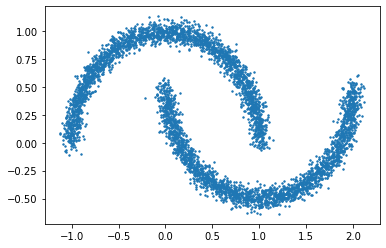

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

batch = generate_batch(5000)

plt.scatter(batch[:,0], batch[:,1], s=2.0)
plt.show()

We now need to define our two neural networks, the generator and the discriminator. The generator will take as input a value $z$ sampled from a Gaussian prior, and output a value $x$ (thus a couple $(x_1,x_2)$). The discriminator takes as input a value $x$, and is a binary classifier.

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch
# Choose a value for the prior dimension
PRIOR_N = 2

# Define the generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(PRIOR_N, 2)
        
    def __call__(self, z):
        return self.fc1(z)
    
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        return self.__call__(z)
    

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 1)
    
    def __call__(self, x):
        return self.fc1(x)

With these classes in shape, now is only needed the training loop. To stick with the mathematical GAN framework, we should train the discriminator until convergence between each training step of the generator. This is not practical for two reasons: first it takes a lot of time, and second if the discriminator is too good, it will generate vanishing gradients to the generator (as seen in **Q4**).

We will thus train the discriminator a fixed number of times between each training iteration of the generator.

step 0: discriminator: 1.405e+00, generator: 8.420e-01


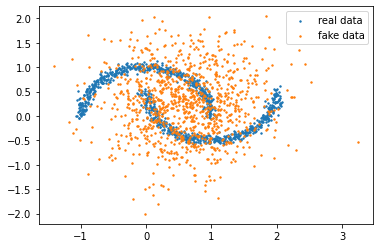

step 1000: discriminator: 1.375e+00, generator: 6.983e-01


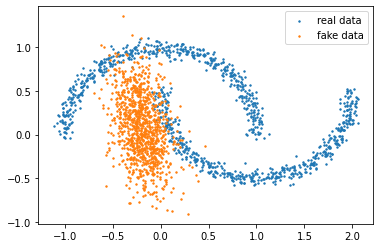

step 2000: discriminator: 1.386e+00, generator: 6.937e-01


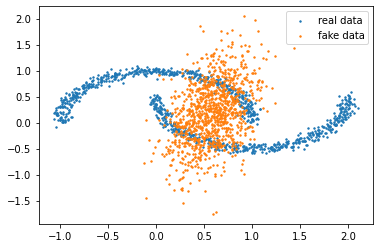

step 3000: discriminator: 1.386e+00, generator: 6.931e-01


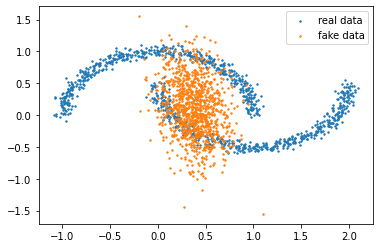

step 4000: discriminator: 1.386e+00, generator: 6.936e-01


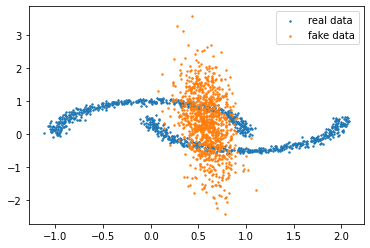

step 5000: discriminator: 1.386e+00, generator: 6.927e-01


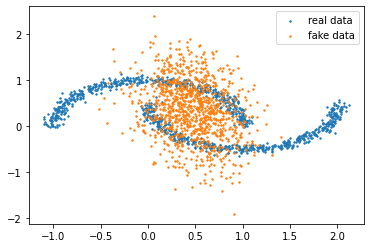

step 6000: discriminator: 1.387e+00, generator: 6.934e-01


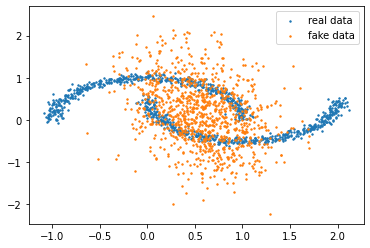

step 7000: discriminator: 1.386e+00, generator: 6.933e-01


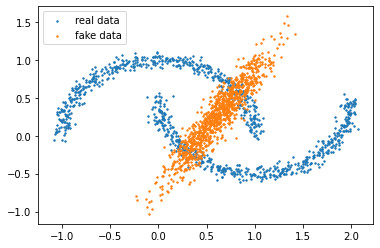

step 8000: discriminator: 1.386e+00, generator: 6.936e-01


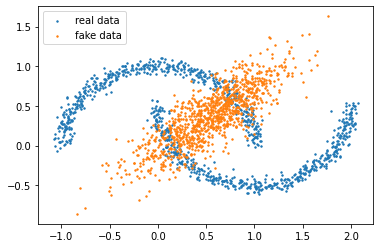

step 9000: discriminator: 1.386e+00, generator: 6.933e-01


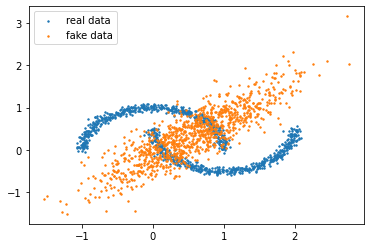

step 10000: discriminator: 1.387e+00, generator: 6.935e-01


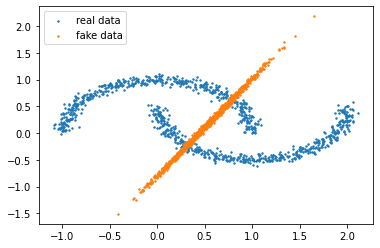

step 11000: discriminator: 1.386e+00, generator: 6.937e-01


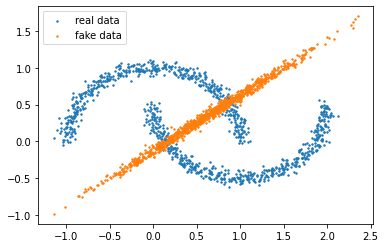

step 12000: discriminator: 1.387e+00, generator: 6.934e-01


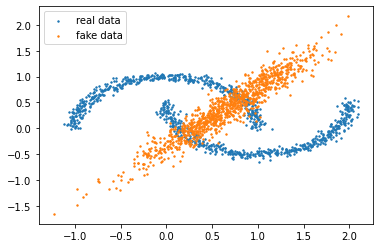

step 13000: discriminator: 1.386e+00, generator: 6.935e-01


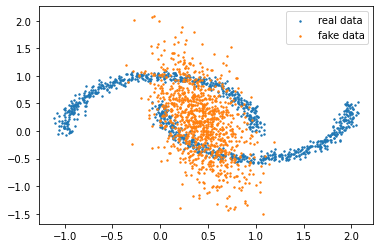

step 14000: discriminator: 1.387e+00, generator: 6.932e-01


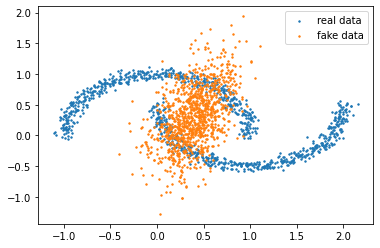

step 15000: discriminator: 1.387e+00, generator: 6.931e-01


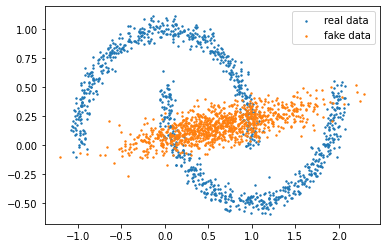

step 16000: discriminator: 1.386e+00, generator: 6.930e-01


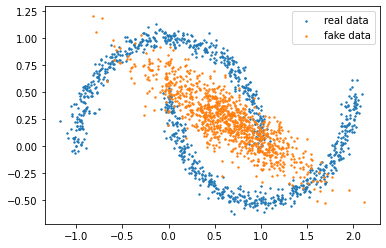

step 17000: discriminator: 1.386e+00, generator: 6.933e-01


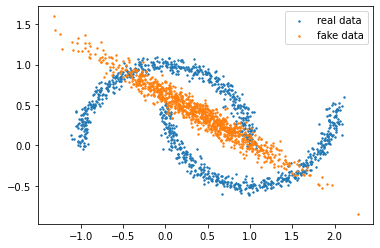

step 18000: discriminator: 1.386e+00, generator: 6.927e-01


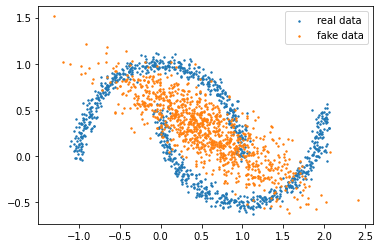

step 19000: discriminator: 1.386e+00, generator: 6.941e-01


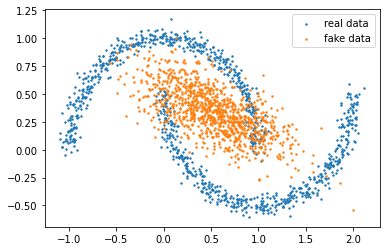

step 20000: discriminator: 1.386e+00, generator: 6.933e-01


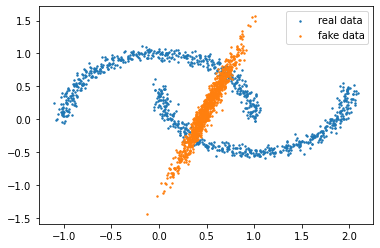

In [4]:
# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 1
# Total number of training iterations for the generator
N_ITER = 20001
# Batch size to use
BATCHLEN = 128

# Modified Lr 0.001 --> 0.01
generator = Generator()
optim_gen = torch.optim.Adam(generator.parameters(), lr=0.01, betas=(0.5,0.9))
discriminator = Discriminator()
optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    # train the discriminator
    for _ in range(TRAIN_RATIO):
        discriminator.zero_grad()
        real_batch = generate_batch(BATCHLEN)
        fake_batch = generator.generate(BATCHLEN)
        #
        # == COMPUTE THE DISCRIMINATOR LOSS HERE ==
        real_outputs = discriminator(real_batch)
        fake_outputs = discriminator(fake_batch)
        disc_loss = F.softplus(-real_outputs) + F.softplus(fake_outputs)
        disc_loss = disc_loss.mean()
        #
        disc_loss.backward()
        optim_disc.step()
        
    # train the generator
    generator.zero_grad()
    fake_batch = generator.generate(BATCHLEN)
    #
    # == COMPUTE THE GENERATOR LOSS HERE
    fake_outputs = discriminator(fake_batch)
    gen_loss = F.softplus(-fake_outputs)
    gen_loss = gen_loss.mean() 
    #
    gen_loss.backward()
    optim_gen.step()
    if i%1000 == 0:
        print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
        # plot the result
        real_batch = generate_batch(1024)
        fake_batch = generator.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

Complete the previous code and train your model.

Depending on your choice of parameters, the training may not go well at all, with the generator completely collapsing quickly at the beginning of the training. It has been observed by the litterature that the generator's loss $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$ is often to blame.

**Q6: Why could we anticipate that this loss could cause this?**

> The values calculated for the loss are $\mathcal{L}_G \in ]-\infty, 0]$. As we can see, this loss is always negative and has no lower bound. In the ideal case where we are able to fool the discriminator perfectly, the value will be equal to $-\infty$, which we cannot escape and which will cause the gradient to vanish. To solve this problem, the authors of the papers proposed in this notebook replace it by $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$ which is nonnegative and has a lower bound equal to $0$.

This issue is solved by replacing the generator loss by an alternative loss: $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$ to avoid gradient vanishing.

**Q7: Inspect the impact of these different factors:**

- depth / width of the generator network
- depth / width of the discriminator network
- impact of `TRAIN_RATIO`

In [5]:
import torch.nn as nn
import torch.nn.functional as F

# Choose a value for the prior dimension
PRIOR_N = 2

# Define the generator
class Generator_upgrade(nn.Module):
    def __init__(self,width=10,depth=2,PRIOR_N = 2):
        super().__init__()
        self.width = width
        self.depth = depth
        self.PRIOR_N = PRIOR_N
        self.fc1 = nn.Linear(PRIOR_N, self.width)
        self.layers =nn.ModuleList()
        for i in range(self.depth):
          self.layers.append(nn.Linear(self.width,self.width))
        self.fc2 = nn.Linear(self.width, 2)
        
    def __call__(self, z):
        z = self.fc1(z)
        z = F.relu(z)
        for l in self.layers:
          z = F.relu(l(z))
        return self.fc2(z)
    
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        return self.__call__(z)
    

# Define the discriminator
class Discriminator_upgrade(nn.Module):
    def __init__(self,width=10,depth=2,PRIOR_N = 2):
        super().__init__()
        self.width = width
        self.depth = depth

        self.fc1 = nn.Linear(2, self.width)
        # Add hidden layers
        self.layers = nn.ModuleList()
        for i in range(self.depth):
          self.layers.append(nn.Linear(self.width,self.width))
        self.fc2 = nn.Linear(self.width, 1)
    
    def __call__(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        for l in self.layers:
          x = F.relu(l(x))
        return self.fc2(x)

In [6]:
# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 1
# Total number of training iterations for the generator
N_ITER = 20001
# Batch size to use
BATCHLEN = 128

def train_gan(TRAIN_RATIO = 1,N_ITER = 10001,BATCHLEN = 128, lr=0.001, depth_g = 2,width_g=10,depth_d = 2,width_d=10,plot_all = False) :

  generator = Generator_upgrade(width=width_g , depth =depth_g )
  optim_gen = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5,0.9))
  discriminator = Discriminator_upgrade(width=width_d , depth =depth_d)
  optim_disc = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5,0.9))

  for i in range(N_ITER):
      # train the discriminator
      for _ in range(TRAIN_RATIO):
          discriminator.zero_grad()
          real_batch = generate_batch(BATCHLEN)
          fake_batch = generator.generate(BATCHLEN)
          #
          # == COMPUTE THE DISCRIMINATOR LOSS HERE ==
          real_outputs = discriminator(real_batch)
          fake_outputs = discriminator(fake_batch)
          disc_loss = F.softplus(-real_outputs) + F.softplus(fake_outputs)
          disc_loss = disc_loss.mean()
          #
          disc_loss.backward()
          optim_disc.step()
      # train the generator
      generator.zero_grad()
      fake_batch = generator.generate(BATCHLEN)
      #
      # == COMPUTE THE GENERATOR LOSS HERE
      fake_outputs = discriminator(fake_batch)
      gen_loss = F.softplus(-fake_outputs)
      gen_loss = gen_loss.mean() 
      #
      gen_loss.backward()
      optim_gen.step()
      if ((plot_all == True) and (i%1000 == 0)):
          print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
          # plot the result
          real_batch = generate_batch(1024)
          fake_batch = generator.generate(1024).detach()
          plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
          plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
          plt.legend()
          plt.show()
  
  print("After training for {} iteration : discriminator: {:.3e}, generator: {:.3e}".format(N_ITER, float(disc_loss), float(gen_loss)))
  real_batch = generate_batch(1024)
  fake_batch = generator.generate(1024).detach()
  plt.figure(figsize = (8,3) )
  plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
  plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
  plt.legend()
  plt.show()

Parameters: TRAIN_RATIO 1, depth_g 2, depth_d 2, and with width 10
After training for 2001 iteration : discriminator: 1.386e+00, generator: 7.421e-01


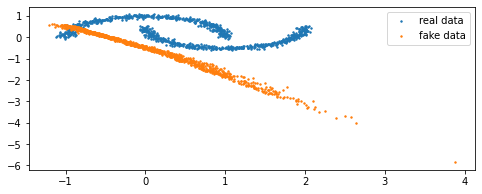


Parameters: TRAIN_RATIO 1, depth_g 2, depth_d 2, and with width 50
After training for 2001 iteration : discriminator: 1.389e+00, generator: 6.952e-01


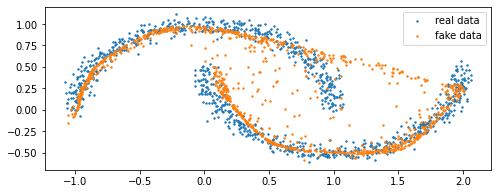


Parameters: TRAIN_RATIO 1, depth_g 2, depth_d 2, and with width 150
After training for 2001 iteration : discriminator: 1.385e+00, generator: 6.901e-01


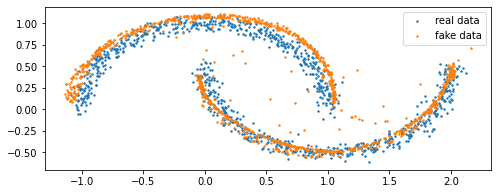


Parameters: TRAIN_RATIO 1, depth_g 2, depth_d 4, and with width 10
After training for 2001 iteration : discriminator: 1.360e+00, generator: 7.476e-01


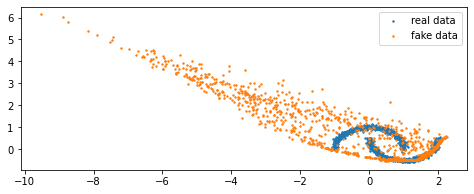


Parameters: TRAIN_RATIO 1, depth_g 2, depth_d 4, and with width 50
After training for 2001 iteration : discriminator: 1.382e+00, generator: 6.787e-01


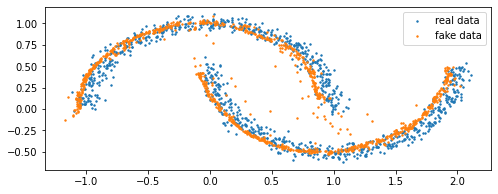


Parameters: TRAIN_RATIO 1, depth_g 2, depth_d 4, and with width 150
After training for 2001 iteration : discriminator: 1.339e+00, generator: 7.413e-01


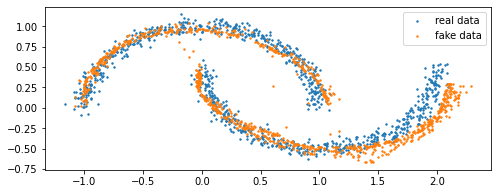


Parameters: TRAIN_RATIO 1, depth_g 2, depth_d 10, and with width 10
After training for 2001 iteration : discriminator: 1.377e+00, generator: 7.121e-01


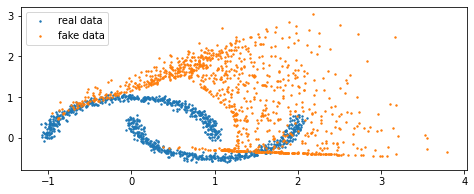


Parameters: TRAIN_RATIO 1, depth_g 2, depth_d 10, and with width 50
After training for 2001 iteration : discriminator: 1.367e+00, generator: 7.782e-01


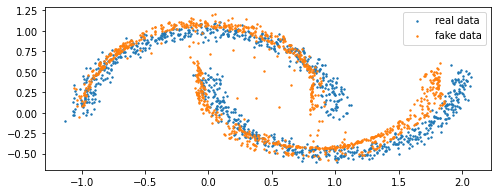


Parameters: TRAIN_RATIO 1, depth_g 2, depth_d 10, and with width 150
After training for 2001 iteration : discriminator: 1.376e+00, generator: 7.314e-01


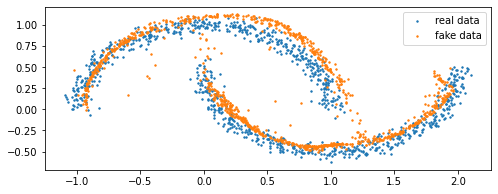


Parameters: TRAIN_RATIO 1, depth_g 4, depth_d 2, and with width 10
After training for 2001 iteration : discriminator: 1.409e+00, generator: 6.221e-01


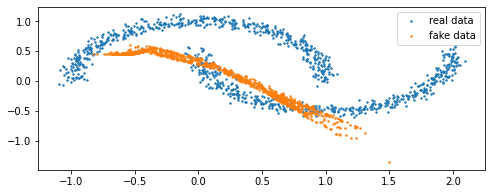


Parameters: TRAIN_RATIO 1, depth_g 4, depth_d 2, and with width 50
After training for 2001 iteration : discriminator: 1.719e+00, generator: 4.339e-01


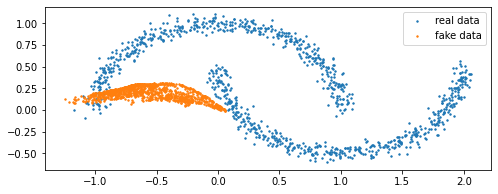


Parameters: TRAIN_RATIO 1, depth_g 4, depth_d 2, and with width 150
After training for 2001 iteration : discriminator: 1.359e+00, generator: 7.896e-01


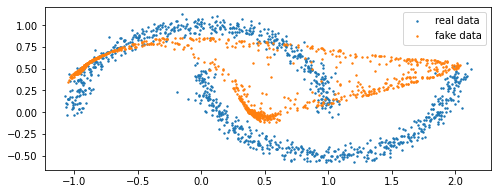


Parameters: TRAIN_RATIO 1, depth_g 4, depth_d 4, and with width 10
After training for 2001 iteration : discriminator: 1.315e+00, generator: 6.873e-01


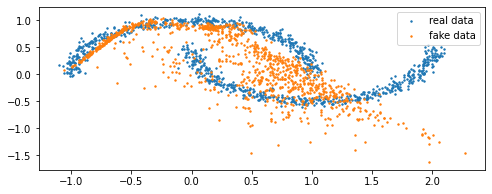


Parameters: TRAIN_RATIO 1, depth_g 4, depth_d 4, and with width 50
After training for 2001 iteration : discriminator: 1.390e+00, generator: 7.010e-01


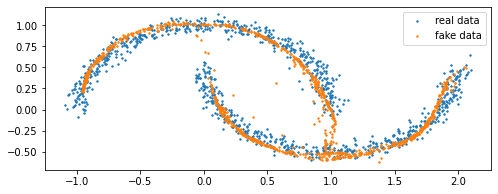


Parameters: TRAIN_RATIO 1, depth_g 4, depth_d 4, and with width 150
After training for 2001 iteration : discriminator: 1.357e+00, generator: 7.174e-01


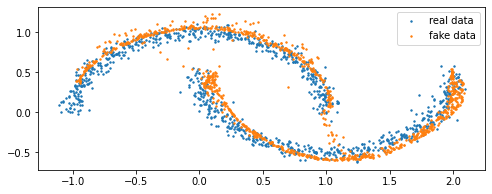


Parameters: TRAIN_RATIO 1, depth_g 4, depth_d 10, and with width 10
After training for 2001 iteration : discriminator: 1.339e+00, generator: 7.633e-01


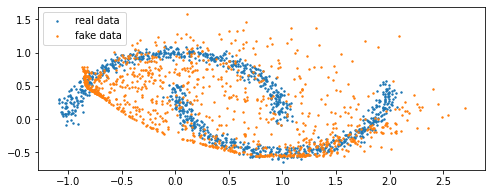


Parameters: TRAIN_RATIO 1, depth_g 4, depth_d 10, and with width 50
After training for 2001 iteration : discriminator: 1.372e+00, generator: 7.009e-01


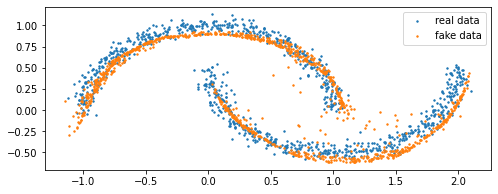


Parameters: TRAIN_RATIO 1, depth_g 4, depth_d 10, and with width 150
After training for 2001 iteration : discriminator: 1.058e+00, generator: 1.095e+00


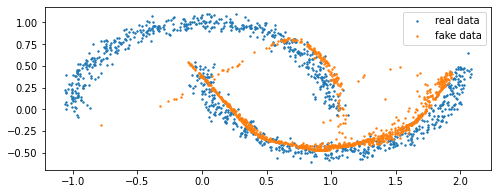


Parameters: TRAIN_RATIO 1, depth_g 10, depth_d 2, and with width 10
After training for 2001 iteration : discriminator: 3.625e-02, generator: 4.644e+00


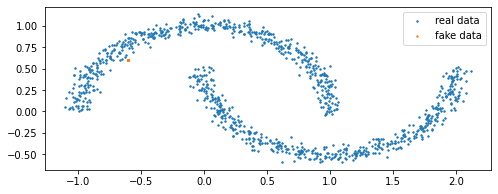


Parameters: TRAIN_RATIO 1, depth_g 10, depth_d 2, and with width 50
After training for 2001 iteration : discriminator: 1.439e+00, generator: 6.653e-01


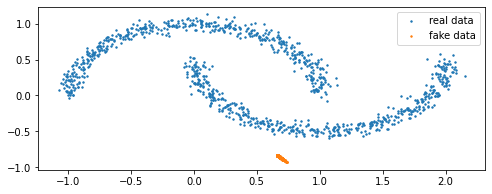


Parameters: TRAIN_RATIO 1, depth_g 10, depth_d 2, and with width 150
After training for 2001 iteration : discriminator: 1.313e+00, generator: 6.584e-01


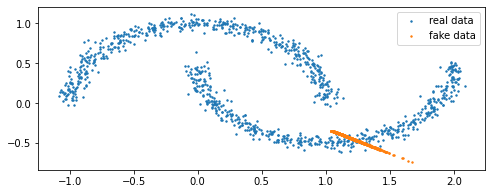


Parameters: TRAIN_RATIO 1, depth_g 10, depth_d 4, and with width 10
After training for 2001 iteration : discriminator: 2.354e-01, generator: 1.660e+00


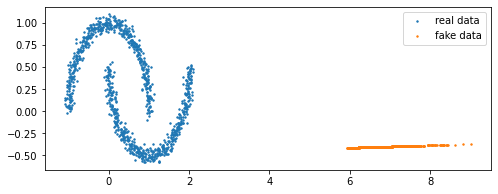


Parameters: TRAIN_RATIO 1, depth_g 10, depth_d 4, and with width 50
After training for 2001 iteration : discriminator: 1.387e+00, generator: 8.886e-01


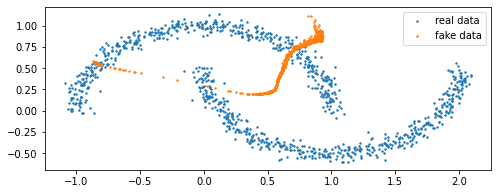


Parameters: TRAIN_RATIO 1, depth_g 10, depth_d 4, and with width 150
After training for 2001 iteration : discriminator: 1.486e+00, generator: 6.669e-01


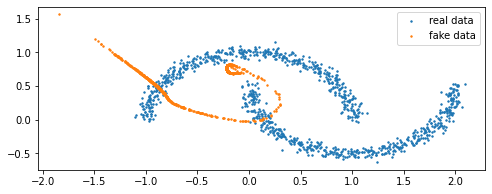


Parameters: TRAIN_RATIO 1, depth_g 10, depth_d 10, and with width 10
After training for 2001 iteration : discriminator: 1.245e+00, generator: 8.898e-01


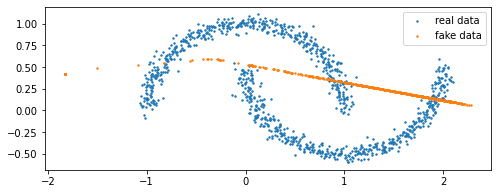


Parameters: TRAIN_RATIO 1, depth_g 10, depth_d 10, and with width 50
After training for 2001 iteration : discriminator: 1.357e+00, generator: 5.524e-01


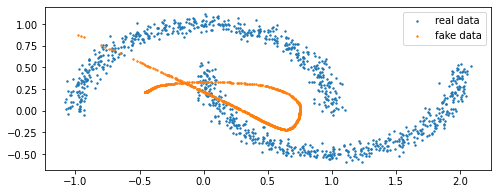


Parameters: TRAIN_RATIO 1, depth_g 10, depth_d 10, and with width 150
After training for 2001 iteration : discriminator: 1.056e+00, generator: 8.218e-01


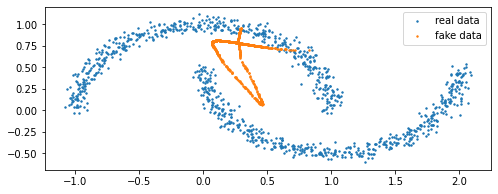


Parameters: TRAIN_RATIO 3, depth_g 2, depth_d 2, and with width 10
After training for 2001 iteration : discriminator: 1.341e+00, generator: 7.612e-01


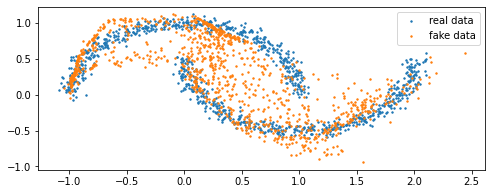


Parameters: TRAIN_RATIO 3, depth_g 2, depth_d 2, and with width 50
After training for 2001 iteration : discriminator: 1.371e+00, generator: 7.107e-01


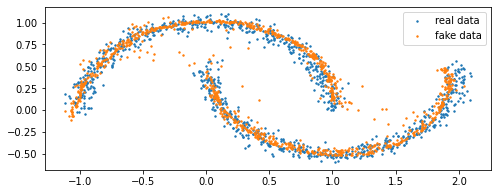


Parameters: TRAIN_RATIO 3, depth_g 2, depth_d 2, and with width 150
After training for 2001 iteration : discriminator: 1.374e+00, generator: 7.106e-01


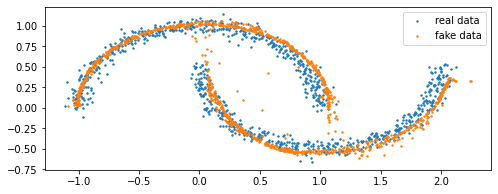


Parameters: TRAIN_RATIO 3, depth_g 2, depth_d 4, and with width 10
After training for 2001 iteration : discriminator: 1.177e+00, generator: 1.072e+00


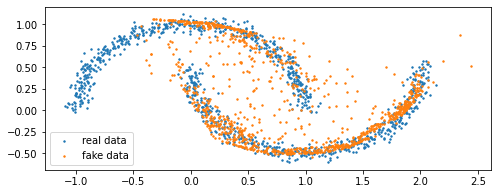


Parameters: TRAIN_RATIO 3, depth_g 2, depth_d 4, and with width 50
After training for 2001 iteration : discriminator: 1.347e+00, generator: 7.251e-01


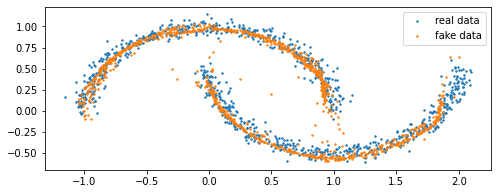


Parameters: TRAIN_RATIO 3, depth_g 2, depth_d 4, and with width 150
After training for 2001 iteration : discriminator: 1.375e+00, generator: 7.873e-01


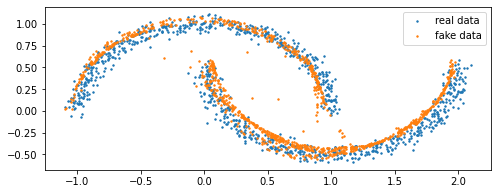


Parameters: TRAIN_RATIO 3, depth_g 2, depth_d 10, and with width 10
After training for 2001 iteration : discriminator: 9.567e-01, generator: 1.662e+00


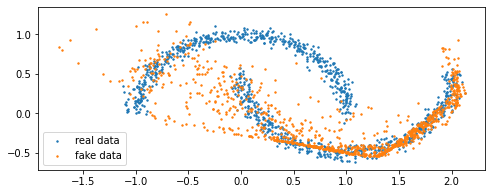


Parameters: TRAIN_RATIO 3, depth_g 2, depth_d 10, and with width 50
After training for 2001 iteration : discriminator: 1.301e+00, generator: 9.275e-01


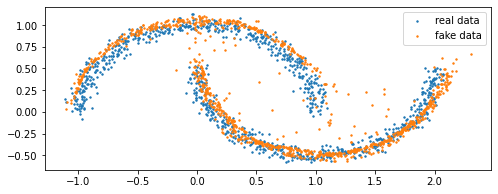


Parameters: TRAIN_RATIO 3, depth_g 2, depth_d 10, and with width 150
After training for 2001 iteration : discriminator: 1.348e+00, generator: 7.057e-01


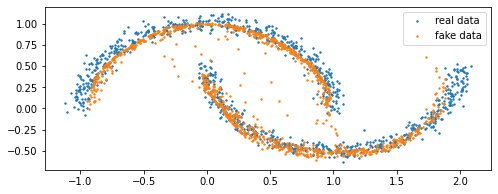


Parameters: TRAIN_RATIO 3, depth_g 4, depth_d 2, and with width 10
After training for 2001 iteration : discriminator: 1.195e+00, generator: 9.453e-01


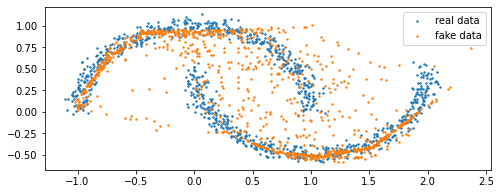


Parameters: TRAIN_RATIO 3, depth_g 4, depth_d 2, and with width 50
After training for 2001 iteration : discriminator: 1.391e+00, generator: 6.827e-01


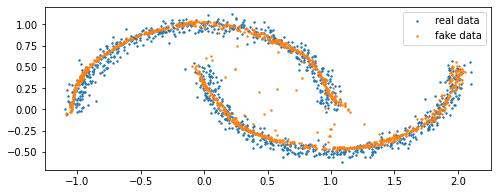


Parameters: TRAIN_RATIO 3, depth_g 4, depth_d 2, and with width 150
After training for 2001 iteration : discriminator: 1.391e+00, generator: 6.982e-01


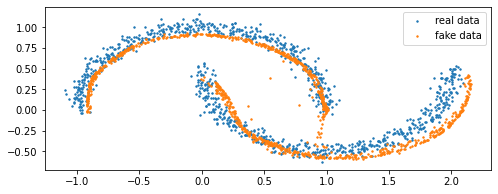


Parameters: TRAIN_RATIO 3, depth_g 4, depth_d 4, and with width 10
After training for 2001 iteration : discriminator: 1.199e+00, generator: 8.921e-01


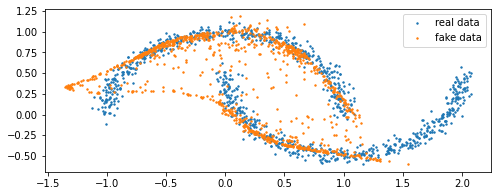


Parameters: TRAIN_RATIO 3, depth_g 4, depth_d 4, and with width 50
After training for 2001 iteration : discriminator: 1.365e+00, generator: 8.029e-01


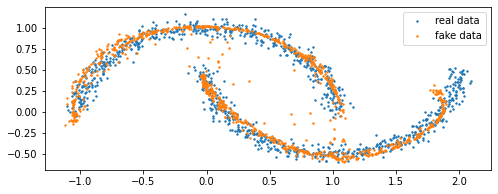


Parameters: TRAIN_RATIO 3, depth_g 4, depth_d 4, and with width 150
After training for 2001 iteration : discriminator: 1.297e+00, generator: 7.822e-01


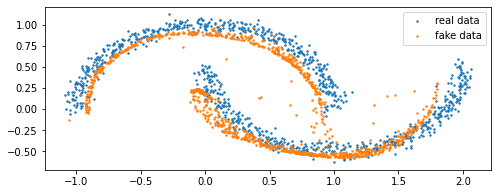


Parameters: TRAIN_RATIO 3, depth_g 4, depth_d 10, and with width 10
After training for 2001 iteration : discriminator: 9.838e-01, generator: 8.217e-01


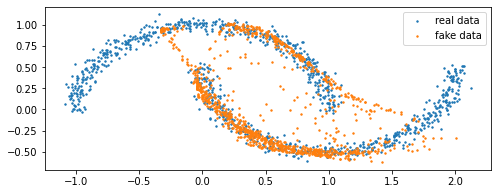


Parameters: TRAIN_RATIO 3, depth_g 4, depth_d 10, and with width 50
After training for 2001 iteration : discriminator: 1.261e+00, generator: 9.007e-01


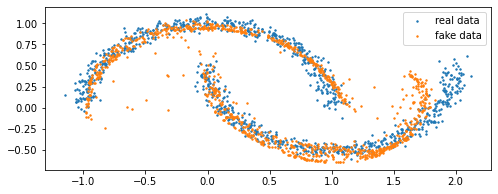


Parameters: TRAIN_RATIO 3, depth_g 4, depth_d 10, and with width 150
After training for 2001 iteration : discriminator: 8.737e-01, generator: 1.290e+00


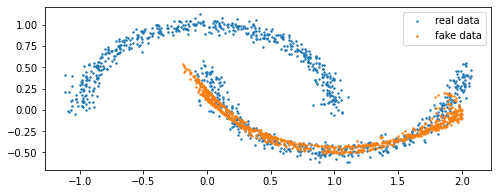


Parameters: TRAIN_RATIO 3, depth_g 10, depth_d 2, and with width 10
After training for 2001 iteration : discriminator: 1.371e+00, generator: 9.247e-01


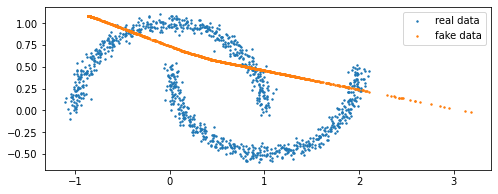


Parameters: TRAIN_RATIO 3, depth_g 10, depth_d 2, and with width 50
After training for 2001 iteration : discriminator: 1.406e+00, generator: 7.407e-01


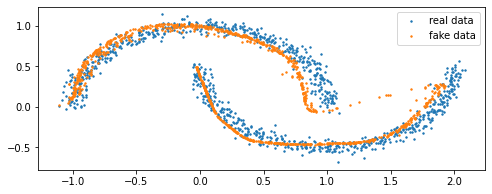


Parameters: TRAIN_RATIO 3, depth_g 10, depth_d 2, and with width 150
After training for 2001 iteration : discriminator: 1.376e+00, generator: 6.984e-01


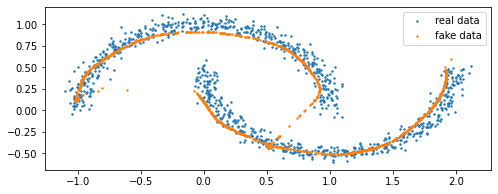


Parameters: TRAIN_RATIO 3, depth_g 10, depth_d 4, and with width 10
After training for 2001 iteration : discriminator: 1.347e+00, generator: 1.179e+00


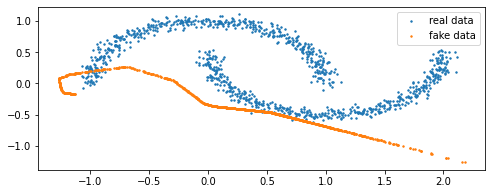


Parameters: TRAIN_RATIO 3, depth_g 10, depth_d 4, and with width 50
After training for 2001 iteration : discriminator: 1.385e+00, generator: 6.696e-01


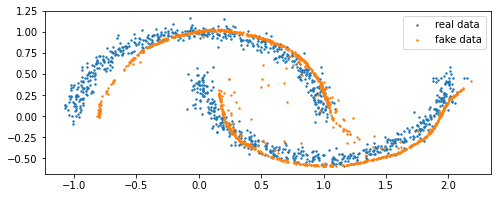


Parameters: TRAIN_RATIO 3, depth_g 10, depth_d 4, and with width 150
After training for 2001 iteration : discriminator: 1.371e+00, generator: 7.125e-01


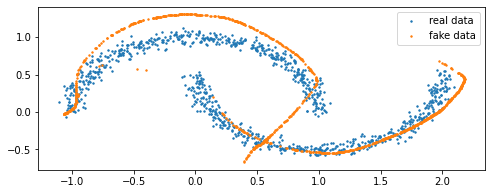


Parameters: TRAIN_RATIO 3, depth_g 10, depth_d 10, and with width 10
After training for 2001 iteration : discriminator: 5.937e-01, generator: 1.726e+00


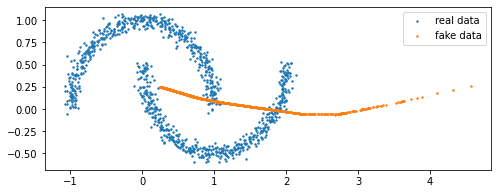


Parameters: TRAIN_RATIO 3, depth_g 10, depth_d 10, and with width 50
After training for 2001 iteration : discriminator: 1.239e+00, generator: 8.417e-01


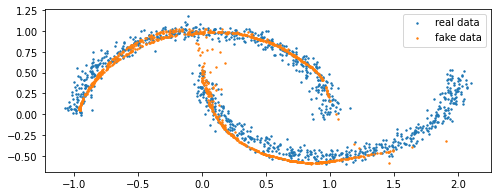


Parameters: TRAIN_RATIO 3, depth_g 10, depth_d 10, and with width 150
After training for 2001 iteration : discriminator: 1.142e+00, generator: 9.807e-01


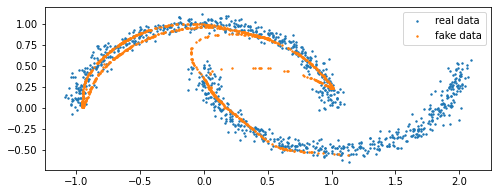


Parameters: TRAIN_RATIO 5, depth_g 2, depth_d 2, and with width 10
After training for 2001 iteration : discriminator: 1.387e+00, generator: 6.986e-01


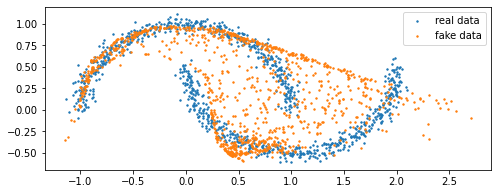


Parameters: TRAIN_RATIO 5, depth_g 2, depth_d 2, and with width 50
After training for 2001 iteration : discriminator: 1.394e+00, generator: 6.850e-01


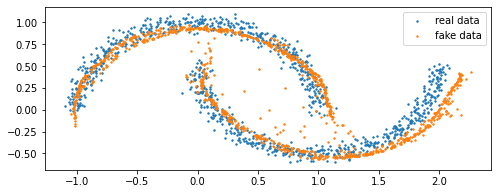


Parameters: TRAIN_RATIO 5, depth_g 2, depth_d 2, and with width 150
After training for 2001 iteration : discriminator: 1.382e+00, generator: 7.216e-01


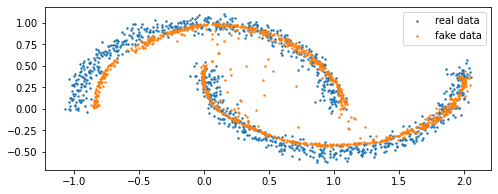


Parameters: TRAIN_RATIO 5, depth_g 2, depth_d 4, and with width 10
After training for 2001 iteration : discriminator: 1.103e+00, generator: 9.851e-01


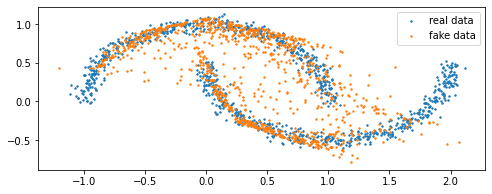


Parameters: TRAIN_RATIO 5, depth_g 2, depth_d 4, and with width 50
After training for 2001 iteration : discriminator: 1.137e+00, generator: 1.086e+00


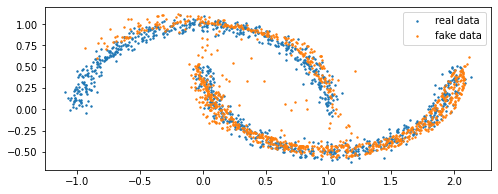


Parameters: TRAIN_RATIO 5, depth_g 2, depth_d 4, and with width 150
After training for 2001 iteration : discriminator: 1.297e+00, generator: 8.876e-01


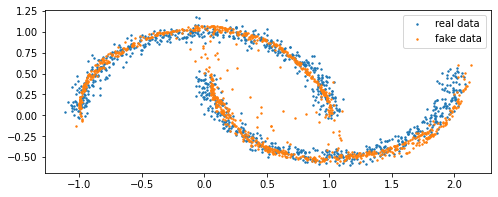


Parameters: TRAIN_RATIO 5, depth_g 2, depth_d 10, and with width 10
After training for 2001 iteration : discriminator: 9.325e-01, generator: 1.405e+00


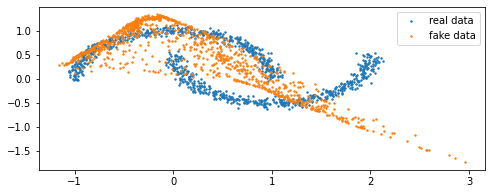


Parameters: TRAIN_RATIO 5, depth_g 2, depth_d 10, and with width 50
After training for 2001 iteration : discriminator: 1.373e+00, generator: 7.449e-01


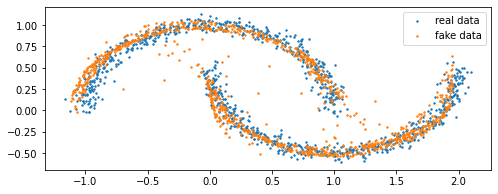


Parameters: TRAIN_RATIO 5, depth_g 2, depth_d 10, and with width 150
After training for 2001 iteration : discriminator: 8.690e-01, generator: 1.460e+00


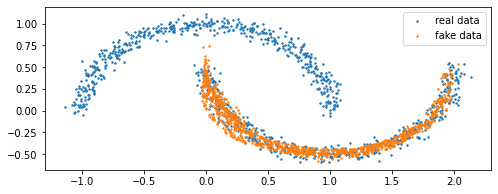


Parameters: TRAIN_RATIO 5, depth_g 4, depth_d 2, and with width 10
After training for 2001 iteration : discriminator: 1.357e+00, generator: 6.839e-01


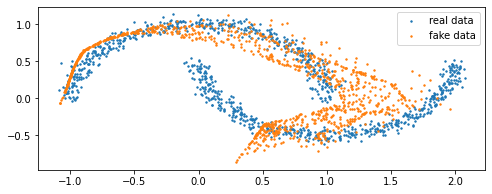


Parameters: TRAIN_RATIO 5, depth_g 4, depth_d 2, and with width 50
After training for 2001 iteration : discriminator: 1.393e+00, generator: 7.310e-01


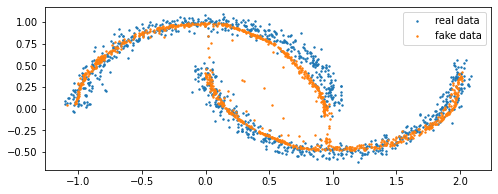


Parameters: TRAIN_RATIO 5, depth_g 4, depth_d 2, and with width 150
After training for 2001 iteration : discriminator: 1.348e+00, generator: 7.478e-01


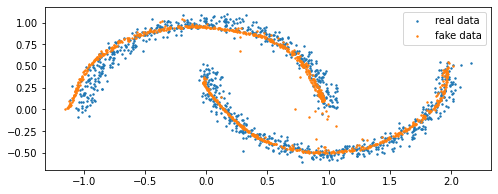


Parameters: TRAIN_RATIO 5, depth_g 4, depth_d 4, and with width 10
After training for 2001 iteration : discriminator: 1.341e+00, generator: 7.806e-01


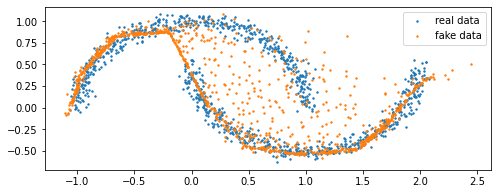


Parameters: TRAIN_RATIO 5, depth_g 4, depth_d 4, and with width 50
After training for 2001 iteration : discriminator: 9.661e-01, generator: 1.037e+00


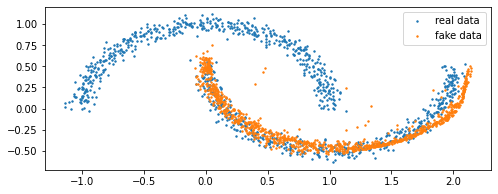


Parameters: TRAIN_RATIO 5, depth_g 4, depth_d 4, and with width 150
After training for 2001 iteration : discriminator: 1.066e+00, generator: 1.059e+00


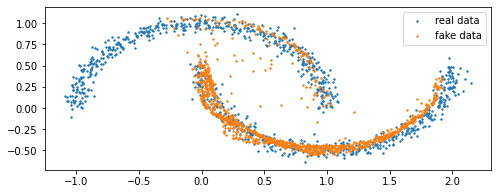


Parameters: TRAIN_RATIO 5, depth_g 4, depth_d 10, and with width 10
After training for 2001 iteration : discriminator: 9.873e-01, generator: 1.093e+00


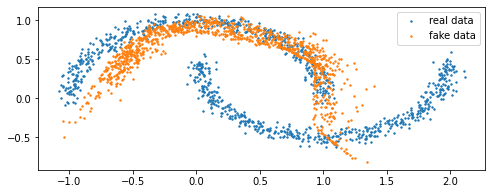


Parameters: TRAIN_RATIO 5, depth_g 4, depth_d 10, and with width 50
After training for 2001 iteration : discriminator: 9.308e-01, generator: 1.206e+00


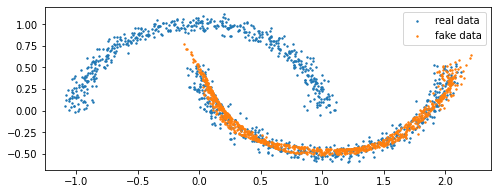


Parameters: TRAIN_RATIO 5, depth_g 4, depth_d 10, and with width 150
After training for 2001 iteration : discriminator: 8.529e-01, generator: 1.245e+00


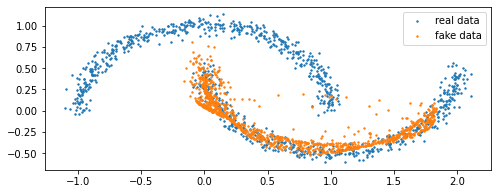


Parameters: TRAIN_RATIO 5, depth_g 10, depth_d 2, and with width 10
After training for 2001 iteration : discriminator: 1.386e+00, generator: 6.933e-01


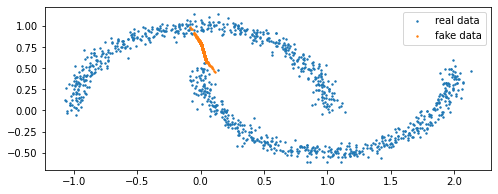


Parameters: TRAIN_RATIO 5, depth_g 10, depth_d 2, and with width 50
After training for 2001 iteration : discriminator: 1.377e+00, generator: 6.927e-01


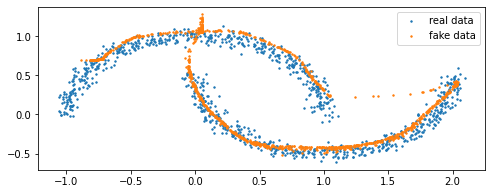


Parameters: TRAIN_RATIO 5, depth_g 10, depth_d 2, and with width 150
After training for 2001 iteration : discriminator: 1.368e+00, generator: 7.695e-01


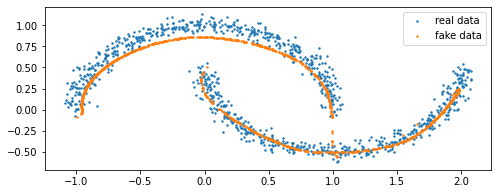


Parameters: TRAIN_RATIO 5, depth_g 10, depth_d 4, and with width 10
After training for 2001 iteration : discriminator: 1.338e+00, generator: 7.577e-01


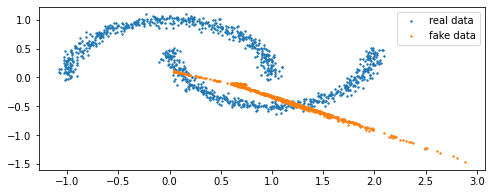


Parameters: TRAIN_RATIO 5, depth_g 10, depth_d 4, and with width 50
After training for 2001 iteration : discriminator: 1.403e+00, generator: 7.270e-01


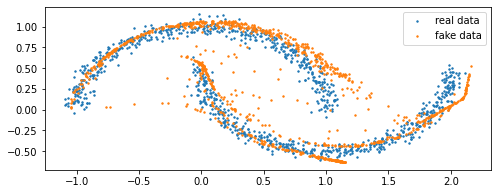


Parameters: TRAIN_RATIO 5, depth_g 10, depth_d 4, and with width 150
After training for 2001 iteration : discriminator: 1.355e+00, generator: 7.296e-01


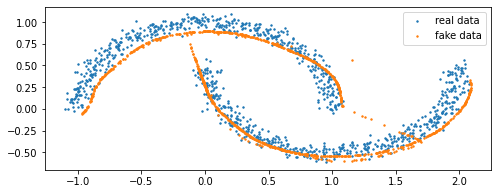


Parameters: TRAIN_RATIO 5, depth_g 10, depth_d 10, and with width 10
After training for 2001 iteration : discriminator: 1.010e+00, generator: 1.262e+00


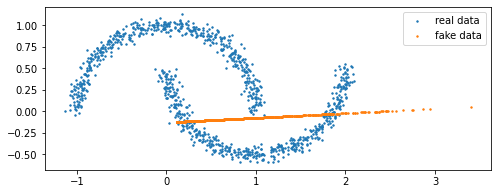


Parameters: TRAIN_RATIO 5, depth_g 10, depth_d 10, and with width 50
After training for 2001 iteration : discriminator: 1.031e+00, generator: 1.280e+00


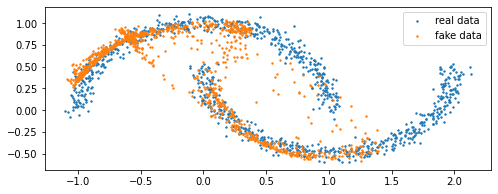


Parameters: TRAIN_RATIO 5, depth_g 10, depth_d 10, and with width 150
After training for 2001 iteration : discriminator: 1.277e+00, generator: 1.117e+00


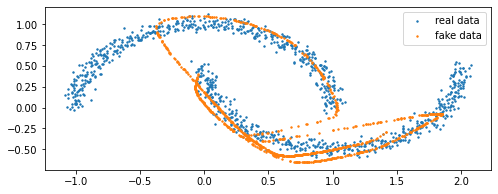

In [7]:
for TRAIN_RATIO in [1,3,5]:
    for depth_g in [2,4,10]:
        for depth_d in [2,4,10]:
            for width in [10,50,150]:
                print('Parameters: TRAIN_RATIO {}, depth_g {}, depth_d {}, and with width {}'.format(TRAIN_RATIO, depth_g, depth_d, width))
                train_gan(TRAIN_RATIO = TRAIN_RATIO ,N_ITER = 2001, depth_g = depth_g ,width_g=width ,depth_d = depth_d,width_d=width, plot_all = False)
                print()

**Answer:**

> We have trained the GAN using different combinations of parameters to study their impact and to come up with conclusions. Here are the different parameters that we used to generate all the above combinations:
  * TRAIN_RATIO: [1,3,5]
  * Generator's Depth:: [2,4,10]
  * Discriminator's Depth: [2,4,10]
  * Width (for both the generator and the discriminator): [50,100,150] <br>
> 
> **Train ratio:** <br> After inspecting the results obtained, we can notice that when we set the value of TRAIN_RATIO to 1, the generator created enough samples to represent correctly the whole distribution but with some outliers. In the other hand, when we set this value to 5, we can clearly see that in most cases, we fail to generate enough samples to represent the whole distribution of the data and sometimes (for certain depth_g and depth_d) we only fit one part of the moon. Setting this value in between (equal to 3), produced the best performance when we take the optimal choice for other parameters.<br><br>
>
> **Generator's and Discriminator's Depth:** <br> For these parameters, we can observe (for any value of TRAIN_RATIO) that when the depth of the discriminator is greater than the depth of the generator, we get a good fit of the data. When it is the opposite, we notice that we poorly generate the samples and that we poorly adjust the real data. When looking closer, we can also say that increasing the depth of the generator reduces the variance of the generated samples but also increases the bias. As for the observation of the effect of the depth of the discriminator alone, we can clearly see that by increasing its value we have a better fit of the data. <br><br>
>
> **Generator's and Discriminator's Width:** <br> We notice that selecting extreme value of the width (too small (10) and too large (150)), leads to bad results for both the generator and the discriminator. Selecting in between value (50), with the convenient choice of the values of TRAIN_RATIO and the generator's and discriminator's Depth produce the best fit for the real data.

For further readings on GANs, you can see the following papers:

- Generative Adversarial Networks *(Goodfellow et al.)*: [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks *(Radford et al.)*: [arXiv:1511.06434](https://arxiv.org/abs/1511.06434)
- A Style-Based Generator Architecture for Generative Adversarial Networks *(Karras et al.)* [arxiv:1812.04948v3](https://arxiv.org/abs/1812.04948v3)

### Variational AutoEncoders

Another well-known approach to generative modelling is embodied by Variational AutoEncoders (VAEs). While the generative model itself and the procedure to sample it is similar to GANs, the way it is trained is not.

The main goal of VAEs is to optimize the likelihood of the real data according to the generative model. In other words, maximize $\mathbb{E}_{p_D} \left[\log p_\theta(x) \right ]$, which is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$.
$$D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_\theta}) \right]$$

**Q8: Prove this equivalence.**

> Taking into account the linearity of expectation, we have:
>
> $$D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_\theta}) \right] = \mathbb{E}_{p_D}\left[ log(p_D) \right] - \mathbb{E}_{p_D}\left[ log(p_\theta) \right]$$ 
> <br>
> Since $ \mathbb{E}_{p_D}\left[ log(p_D) \right] $ doesn't depend on $\theta$: 
> <br><br>
 $$\boxed{\text{Maximizing} \: \:  \mathbb{E}_{p_D}\left[ log(p_\theta(x)) \right] \Longleftrightarrow  \text{Minimizing} \: \: D_{KL}(p_D \| p_\theta) }$$

However, the classes of distributions for which $\log p_\theta(x)$ can be analytically computed and optimized is very restricted, and not suitable for real world problems. The main idea of the VAE is thus to introduce a latent variable $z$ and decompose the distribution as: $p_\theta(x, z) = p_\theta(x | z) p(z)$. Here $p(z)$ is some fixed prior and $p_\theta(x | z)$ is a simple distribution whose parameters are the output of a neural network.

For example, you could have $p(z)$ be a standard $\mathcal{N}(0;1)$ and $p_\theta(x | z)$ be defined as a gaussian $\mathcal{N}(\mu_\theta(z); \sigma_\theta(z))$ where $\mu_\theta(z)$ and $\sigma_\theta(z)$ are created by the neural network you will train. In this case, the resulting distribution $p_\theta(x) = \int_z p_\theta(x|z)p(z)dz$ is an infinite mixture of Gaussians, which is a much more expressive class of distributions.

Now, this cannot stop here, as we are not able to analitically compute the density $p_\theta(x)$. The second main idea of the VAE is to introduce another, auxilliary distribution: $q_\phi(z | x)$, which will be modelled by a neural network similarly to $p_\theta(x | z)$. Introducing it allows us to create a lower bound for $\log p_\theta(x)$:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log p_\theta(x) \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Following Bayes theorem, $p_\theta(x) p_\theta(z|x) = p_\theta(x, z) = p_\theta(x|z) p(z)$, so we get:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log \frac{p_\theta(x|z) p(z)}{p_\theta(z|x)} \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Re-organizing the terms:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log \frac{q_\phi(z|x)}{p_\theta(z|x)} + \mathbb{E}_{z \sim q_\phi} \log \frac{p(z)}{q_\phi(z|x)} + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x | z)$$

This can be re-expressed like so:

$$\log p_\theta(x) = D_{KL}(q_\phi(z | x) \| p_\theta(z | x)) - D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x|z)$$

The 3 terms of this equality can be interpreted like so:

- the first term measures how much $q_\phi(z | x)$ is similar to $p_\theta(z | x)$, or in other words is a good inverse of $p_\theta(x | z)$
- the second term measures how similar $q_\phi(z|x)$ is from the latent prior $p(z)$
- the third term is linked to how likely $p_\theta$ is to yield the given $x$ when $z$ is sampled from $q_\phi(z | x)$ rather than $p(z)$

It is interesting to note that the first term, being a KL-divergence is always positive. As such the combination of the last two terms forms a lower bound of $\log p_\theta(x)$ which *can* be computed and used as a training objective. This bound is called the *Evidence Lower-Bound (ELBO)*. Simply flipping its sign can make it into a loss that can be minimized by gradient descent:

$$ \mathcal{L}_{ELBO} = D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} [ - \log p_\theta(x|z) ]$$

From this formulation comes the parallel with auto-encoders that give the VAE its name: $q_\phi(z | x)$ can be seen as a *probabilistic encoder* from the data $x$ to the latent space $z$, and $p_\theta(x | z)$ can be seen as a *probabilistic decoder* from the latent space $z$ to the data $x$. In this case the second term of $\mathcal{L}_{ELBO}$ is the loss measuring the reconstruction quality of the auto-encoder, and the first term can be seens as a regularization of the latent space.

![VAE](vae-gaussian.png)

**Q9: We can see that $p(z)$ is never sampled during the training process, how can that be a problem?**

> Being a random distribution, when $p(z)$ is not sampled during the training process, poor approximations may be a consequence, not to mention the risk of overfitting the model to the poor approximation and therefore the failure to generalize to different priors. 

A typical choice to represent $q_\phi(z | x)$ is to use a diagonal Gaussian distribution $\mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi^2(x)))$, which makes the KL-divergence term of $\mathcal{L}_{ELBO}$ analytically computable.

**Q10: Assuming $p(z)$ is a $\mathcal{N}(0; Id)$ gaussian, what is the value of $D_{KL}(q_\phi(z | x) \| p(z))$?**

> We have:  
$\left \{
\begin{array}{ll} 
q_\phi(z|x) & \sim \mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi^2(x))) \\  
p(z)&  \sim \mathcal{N}(0; Id)
\end{array}
\right.$
<br><br>
> Hence, <br>
$\left \{
\begin{array}{ll}
q_\phi(z|x)  & = \frac{1}{(2\pi)^{d/2} \det(Diag(\sigma_{\phi}^2))^{1/2}} exp \left( -\frac{1}{2} (z - \mu_{\phi}(x))^T Diag(\sigma_\phi^2(x))^{-1} (z - \mu_{\phi}(x))\right) \\
p(z) & = \frac{1}{(2\pi)^{d/2} } exp \left ( - \frac{1}{2} z^T z \right)
\end{array} 
\right.
$ 
<br><br>
> Thus, <br>
$\begin{array}{ll} 
D_{KL}(q_\phi(z|x) || p(z)) & = \mathbb{E}_{z  \sim  q_{\phi}} log \left( \frac{q_\phi(z|x)}{p(z)}\right) \\
&  = \mathbb{E}_{z \sim q_\phi} \left ( - \log(\det(Diag(\sigma_\phi^2(x)))^{1/2} ) + \frac{1}{2} z^T z - \frac{1}{2} (z-\mu_\phi(x))^TDiag(\sigma_\phi^2(x))^{-1}(z-\mu_\phi(x)) \right) \\
& =  - \frac{1}{2}\log(\det(Diag(\sigma_\phi^2(x))) + \frac{1}{2} \mathbb{E}_{z \sim q_\phi}(Tr(z^T z))  - \frac{1}{2}\mathbb{E}_{z \sim q_\phi}(Tr((z-\mu_\phi(x))^TDiag(\sigma_\phi^2(x))^{-1}(z-\mu_\phi(x)))) \\ 
\end{array} $  
<br><br>
> Using  the trace  trick, <br>
$\begin{array}{ll} 
D_{KL}(q_\phi(z|x) || p(z)) & =  - \frac{1}{2}\log(\det(Diag(\sigma_\phi^2(x))) + \frac{1}{2} \mathbb{E}_{z \sim q_\phi}(Tr(z^T z))  - \frac{1}{2}\mathbb{E}_{z \sim q_\phi}\left(Tr\left((z-\mu_\phi(x))(z-\mu_\phi(x))^TDiag(\sigma_\phi^2(x))^{-1}\right)\right) \\ 
& =  - \frac{1}{2}\log(\det(Diag(\sigma_\phi^2(x))) + \frac{1}{2} \mathbb{E}_{z \sim q_\phi}(Tr(z^T z))  - \frac{1}{2} Tr\left(Diag(\sigma_\phi^2(x)) Diag(\sigma_\phi^2(x))^{-1}\right)\\ 
\end{array}$
$
\begin{array}{ll}
\text{Because,} \\
\mathbb{E}_{z \sim q_\phi}\left(Tr\left((z-\mu_\phi(x))(z-\mu_\phi(x))^TDiag(\sigma_\phi^2(x))^{-1}\right)\right) & = Tr  \left( \mathbb{E}_{z \sim q_\phi}\left((z-\mu_\phi(x))(z-\mu_\phi(x))^T \right) Diag(\sigma_\phi^2(x))^{-1}\right)  = Tr\left(Diag(\sigma_\phi^2(x)) Diag(\sigma_\phi^2(x))^{-1}\right)= Tr(I_d) =  d 
\end{array} $  
$\begin{array}{ll} 
Or, \\
\mathbb{E}_{z \sim q_\phi}(Tr(z^T z)) &= \mathbb{E}_{z \sim q_\phi}(Tr((z-\mu_\phi(x)+\mu_\phi(x))^T(z-\mu_\phi(x)+\mu_\phi(x)))) \\
& = Tr  \left( \mathbb{E}_{z \sim q_\phi}\left((z-\mu_\phi(x))^T(z-\mu_\phi(x))\right) + \mu_\phi(x)^T\mu_\phi(x) + \mathbb{E}_{z \sim q_\phi}\left( \mu_\phi(x)^T (z-\mu_\phi(x)) \right)  +  \mathbb{E}_{z \sim q_\phi}\left( (z-\mu_\phi(x))^T\mu_\phi(x)  \right) \right) \\  
& =  Tr  \left( \mathbb{E}_{z \sim q_\phi}\left((z-\mu_\phi(x))(z-\mu_\phi(x))^T\right) + \mu_\phi(x)^T\mu_\phi(x)  \right) + 0 + 0 \\  
& = Tr  \left( Diag(\sigma_\phi^2(x)) + \mu_\phi(x)^T\mu_\phi(x)\right)  
\end{array}$
> Thus, <br>
$\begin{array}{ll} 
D_{KL}(q_\phi(z|x) || p(z)) & = - \frac{1}{2}\log(\det(Diag(\sigma_\phi^2(x))) + \frac{1}{2} \left( Tr  \left( Diag(\sigma_\phi^2(x))   \right)   + \mu_\phi(x)^T\mu_\phi(x) \right) - \frac{d}{2}  \\
Conclusion: \\
& \boxed{D_{KL}(q_\phi(z | x) \| p(z))= \frac{1}{2} \sum_{i=1}^d \left( \sigma_{\phi_{i}}^2(x) + \mu_{\phi_{i}}(x)^2 - \log(\sigma_{\phi_{i}}^2(x)) - 1 \right) } 
\end{array} $


We will also model $p_\theta(x | z)$ as a diagonal Gaussian $\mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta^2(z)))$.


**Note:** For the following, be careful about the difference between $\mu_\phi, \sigma_\phi$ which define the Gaussian distribution of the *encoder* $q_\phi$ and $\mu_\theta, \sigma_\theta$ which define the Gaussian distribution of the *decoder* $p_\theta$.

**Q11: What is the expression of $-\log p_\theta(x | z)$ for given $x$ and $z$?**

> We have: $$p_\theta(x | z) \sim \mathcal{N}(\mu_\theta(z);\sigma_\theta(z))$$
<br>
Thus,   $$  p_\theta(x | z) = \frac{1}{(2\pi)^{d/2}|Diag(\sigma_\theta(z)^2)|^{1/2}} \exp \left(-\frac{1}{2} (x-\mu_\theta(z))^TDiag\left(\sigma_\theta(z)^2\right)^{-1}(x-\mu_\theta(z))\right)$$
<br>
Applying the neg-log, we obtain: 
$$ - \log p_\theta(x | z) = \frac{1}{2}  ( \log |Diag(\sigma_\theta(z)^2)| + d \log (2 \pi)  + (x-\mu_\theta(z))^T Diag(\sigma_\theta(z)^2)^{-1}(x-\mu_\theta(z)) )
 $$


We will build and train a VAE using the same dataset as previously, in order to compare its behavior to GANs. For numerical stability, we will interpret the output of the encoder and decoder networks as $(\mu, \log\sigma^2)$, rather than $(\mu, \sigma)$.

In [8]:
# Choose a value for the latent dimension
LATENT_N = 10

# Define the generator
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_mu = nn.Linear(2, LATENT_N)
        self.fc_logvar = nn.Linear(2, LATENT_N)
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian q_\phi(z | x)
    def __call__(self, x):
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return (mu, logvar)
    
# Define the discriminator
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_mu = nn.Linear(LATENT_N, 2)
        self.fc_logvar = nn.Linear(LATENT_N, 2)
    
    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian p_\theta(z | x)
    def __call__(self, z):
        mu = self.fc_mu(z)
        logvar = self.fc_logvar(z)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5*logvar))

From this, the parameters of both networks are trained conjointly using the same loss $\mathcal{L}_{ELBO}$. 

step 0: KL: 2.770e+02, rec: 2.575e+03


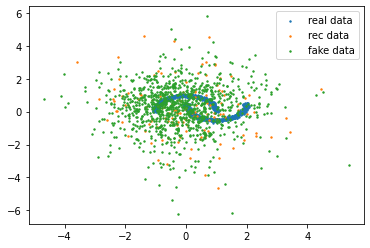

step 1000: KL: 8.417e+00, rec: 2.374e+03


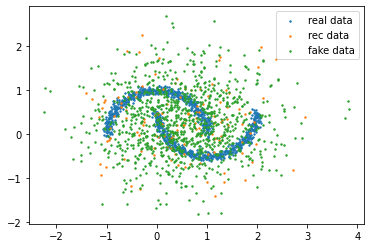

step 2000: KL: 2.497e+01, rec: 2.344e+03


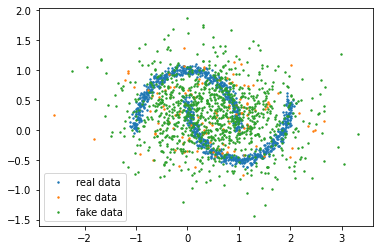

step 3000: KL: 5.193e+01, rec: 2.308e+03


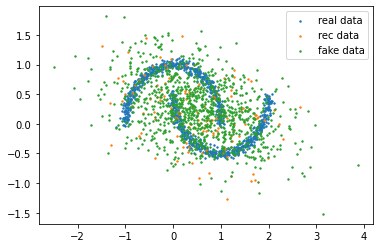

step 4000: KL: 5.907e+01, rec: 2.294e+03


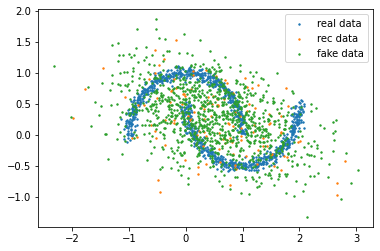

step 5000: KL: 5.996e+01, rec: 2.296e+03


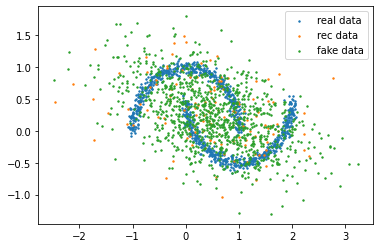

step 6000: KL: 6.345e+01, rec: 2.294e+03


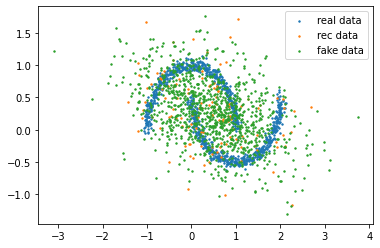

step 7000: KL: 6.299e+01, rec: 2.291e+03


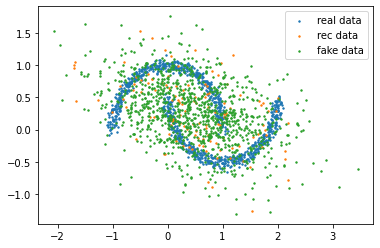

step 8000: KL: 6.174e+01, rec: 2.289e+03


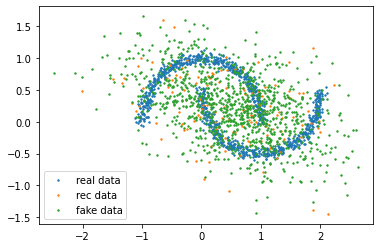

step 9000: KL: 6.538e+01, rec: 2.300e+03


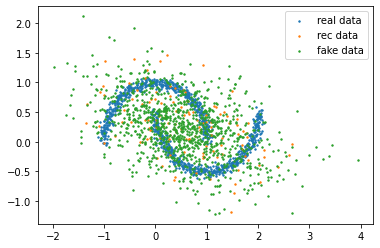

step 10000: KL: 6.348e+01, rec: 2.286e+03


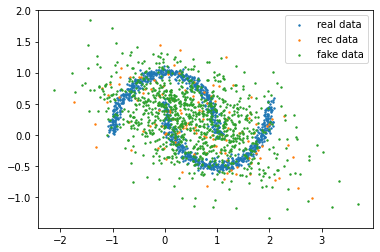

step 11000: KL: 6.509e+01, rec: 2.298e+03


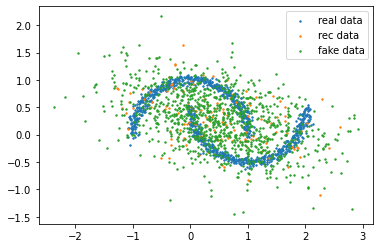

step 12000: KL: 6.402e+01, rec: 2.291e+03


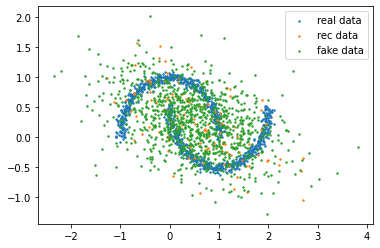

step 13000: KL: 6.620e+01, rec: 2.300e+03


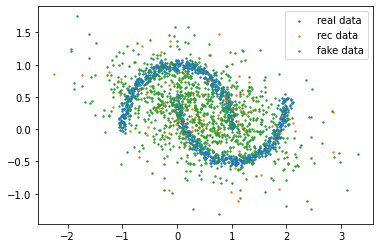

step 14000: KL: 6.489e+01, rec: 2.290e+03


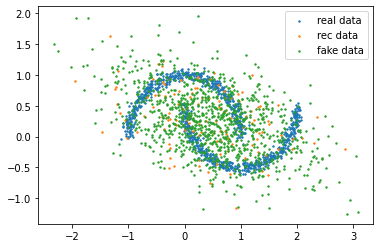

step 15000: KL: 6.667e+01, rec: 2.288e+03


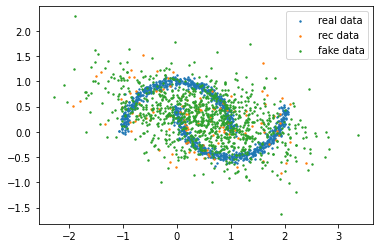

step 16000: KL: 6.333e+01, rec: 2.307e+03


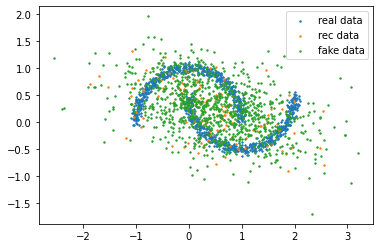

step 17000: KL: 6.146e+01, rec: 2.303e+03


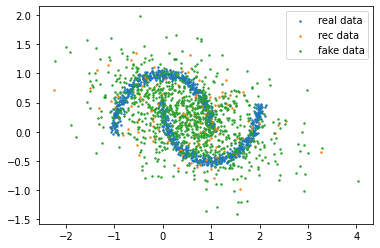

step 18000: KL: 6.243e+01, rec: 2.303e+03


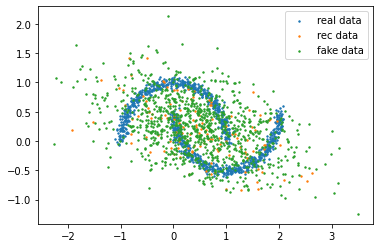

step 19000: KL: 6.362e+01, rec: 2.304e+03


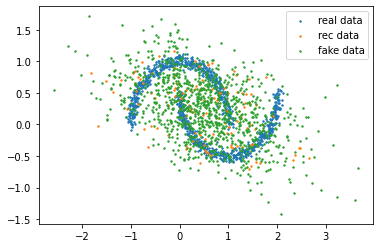

step 20000: KL: 6.608e+01, rec: 2.285e+03


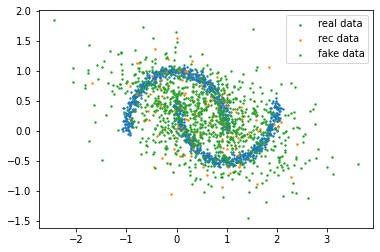

step 21000: KL: 6.392e+01, rec: 2.290e+03


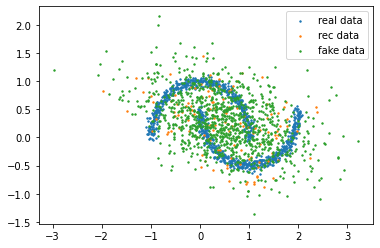

step 22000: KL: 6.348e+01, rec: 2.282e+03


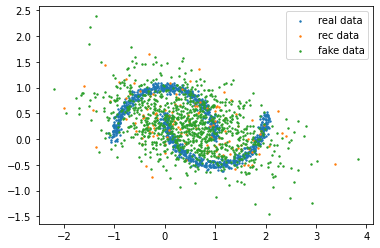

step 23000: KL: 6.316e+01, rec: 2.285e+03


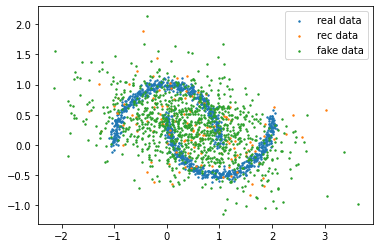

step 24000: KL: 6.146e+01, rec: 2.288e+03


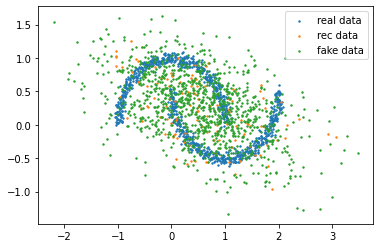

step 25000: KL: 6.175e+01, rec: 2.300e+03


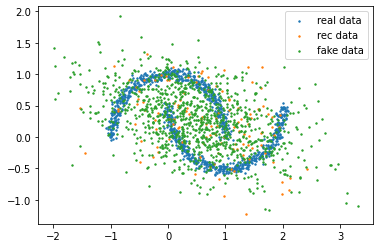

step 26000: KL: 6.448e+01, rec: 2.287e+03


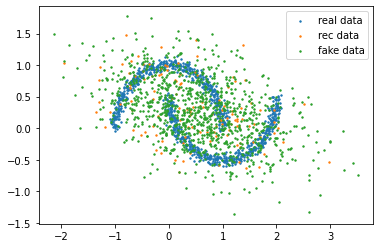

step 27000: KL: 6.218e+01, rec: 2.299e+03


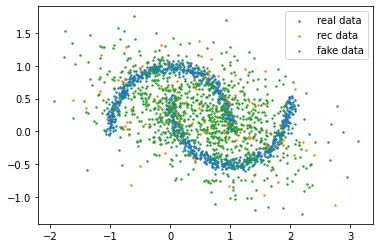

step 28000: KL: 6.284e+01, rec: 2.298e+03


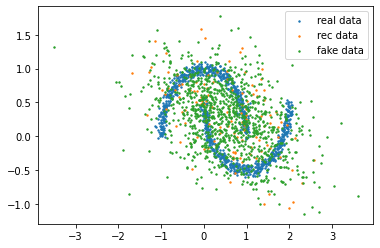

step 29000: KL: 6.370e+01, rec: 2.296e+03


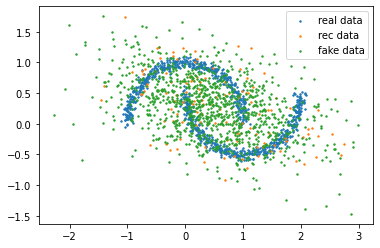

step 30000: KL: 6.434e+01, rec: 2.293e+03


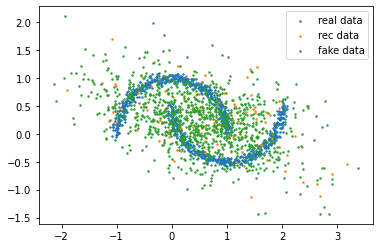

step 31000: KL: 6.437e+01, rec: 2.297e+03


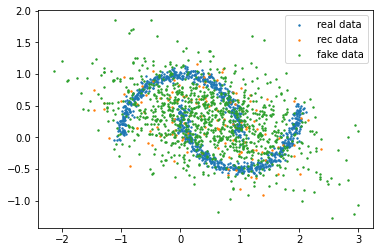

step 32000: KL: 6.695e+01, rec: 2.302e+03


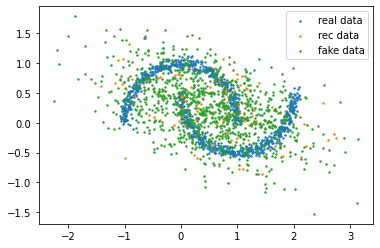

step 33000: KL: 6.679e+01, rec: 2.297e+03


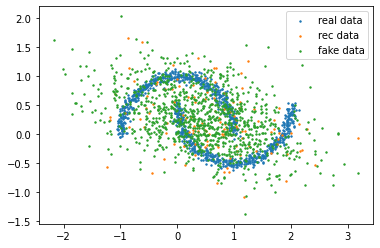

step 34000: KL: 6.517e+01, rec: 2.298e+03


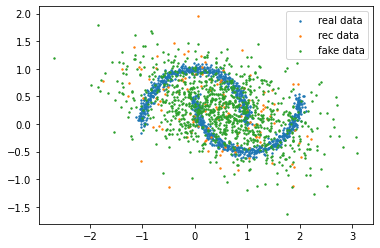

step 35000: KL: 6.304e+01, rec: 2.296e+03


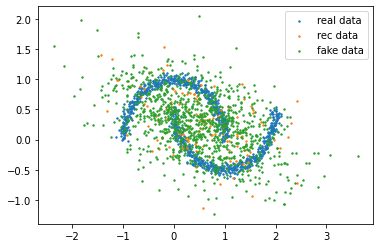

step 36000: KL: 6.663e+01, rec: 2.305e+03


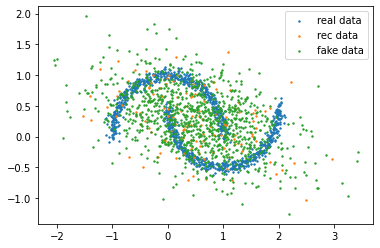

step 37000: KL: 6.495e+01, rec: 2.290e+03


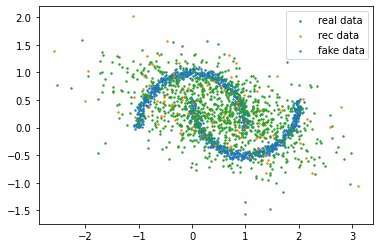

step 38000: KL: 6.280e+01, rec: 2.290e+03


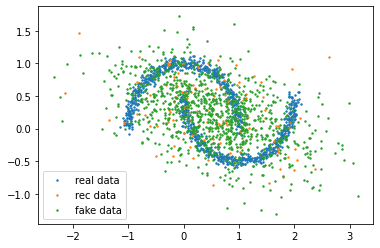

step 39000: KL: 6.345e+01, rec: 2.304e+03


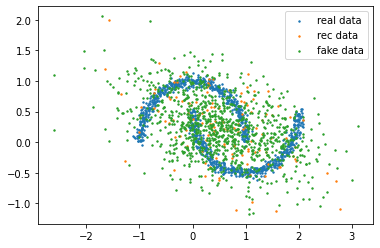

step 40000: KL: 6.624e+01, rec: 2.305e+03


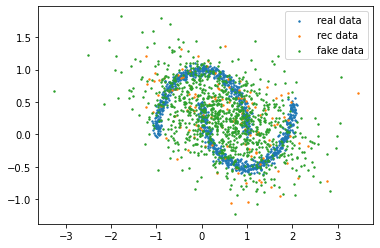

In [9]:
# Total number of training iterations for the VAE
N_ITER = 40001
# Batch size to use
BATCHLEN = 128

encoder = Encoder()
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
decoder = Decoder()
optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()
    
    x = generate_batch(BATCHLEN)
    
    enc_mu, enc_logvar = encoder(x)
    #
    # COMPUTE THE KL PART OF THE LOSS HERE
    #
    loss_kl = 0.5 * torch.sum( torch.exp(enc_logvar) + enc_mu.pow(2) - 1 - enc_logvar)
    #
    # SAMPLE z FROM q(z|x) HERE
    #
    enc_sig = torch.exp(0.5*enc_logvar)
    z = enc_mu + enc_sig * torch.randn((BATCHLEN,LATENT_N))
    
    dec_mu, dec_logvar = decoder(z)
    #
    # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
    #
    loss_rec = 0.5 * torch.sum(dec_logvar + (x - dec_mu).pow(2) * torch.exp(-dec_logvar) + LATENT_N * np.log(2 * np.pi))
    
    (loss_kl + loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if i%1000 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        # plot the result
        real_batch = generate_batch(1024)
        rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
        fake_batch = decoder.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

**Q12: Try hardcoding $\sigma_\theta(z)$ to some small value (like 1E-4) rather than allowing the decoder to learn it. What does it change?**

> * In this question, we will modify the architecture of the model in order to add more hidden layers. We will add $6$ hidden layers, each of hidden size equal to $128$. <br>
> * We will modify the generate function in order to generate random samples with fixed variance equal to $10^{-4}$. <br>
> * We will modify the reconstruction batch as random samples with fixed variance equal to $10^{-4}$. <br>
* By doing so, the encoder-decoder no longer needs to learn the variance of the distribution, it will instead focus primarily on learning the mean of the distribution. <br>
* We plot in the following the results of the generated and  reconstructed data after each $1000$ steps along with the values of the KL and reconstruction losses.

In [21]:
# Choose a value for the latent dimension
LATENT_N = 10

# Modify the generator architecture
class Encoder(nn.Module):
    def __init__(self, n_layers=6, hidden_size=128):
        super().__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.layers = [nn.Linear(2, self.hidden_size), nn.ReLU()]
        
        for i in range(1,self.n_layers) :
          self.layers.append(nn.Linear(self.hidden_size, self.hidden_size))
          self.layers.append(nn.ReLU())

        self.fc = nn.Sequential(*self.layers)
        self.fc_mu = nn.Linear(self.hidden_size, LATENT_N)
        self.fc_logvar = nn.Linear(self.hidden_size, LATENT_N)
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian q_\phi(z | x)
    def __call__(self, x):
        x = self.fc(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return (mu, logvar)

# Modify the discriminator architecture
class Decoder(nn.Module):
    def __init__(self, n_layers=6, hidden_size=128):
        super().__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.layers = [nn.Linear(LATENT_N, self.hidden_size), nn.ReLU()]
        
        for i in range(1,self.n_layers) :
          self.layers.append(nn.Linear(self.hidden_size, self.hidden_size))
          self.layers.append(nn.ReLU())

        self.fc = nn.Sequential(*self.layers)
        self.fc_mu = nn.Linear(self.hidden_size, 2)
        self.fc_logvar = nn.Linear(self.hidden_size, 2)
    
    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian p_\theta(z | x)
    def __call__(self, z):
        z = self.fc(z)
        mu = self.fc_mu(z)
        logvar = self.fc_logvar(z)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, 1e-4)

step 0: KL: 2.211e+00, rec: 2.448e+03


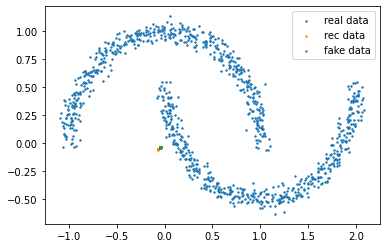

step 1000: KL: 3.844e+02, rec: 1.966e+03


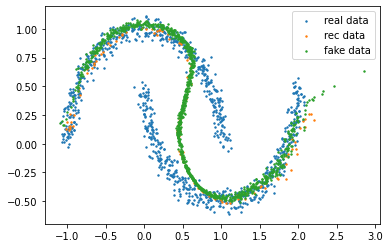

step 2000: KL: 4.400e+02, rec: 1.864e+03


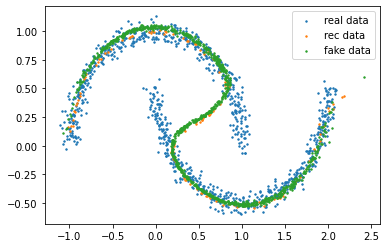

step 3000: KL: 4.875e+02, rec: 1.920e+03


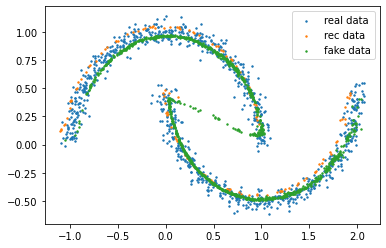

step 4000: KL: 4.869e+02, rec: 1.825e+03


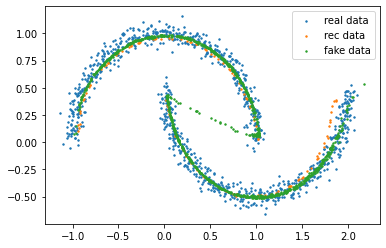

step 5000: KL: 5.133e+02, rec: 1.801e+03


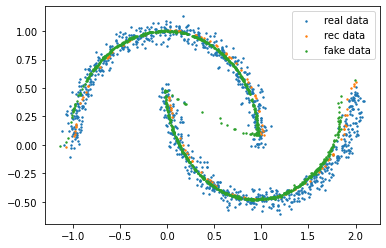

step 6000: KL: 5.085e+02, rec: 1.796e+03


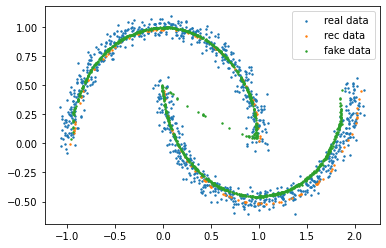

step 7000: KL: 5.187e+02, rec: 1.717e+03


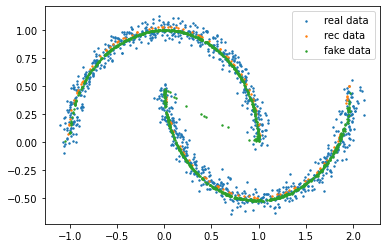

step 8000: KL: 5.049e+02, rec: 1.832e+03


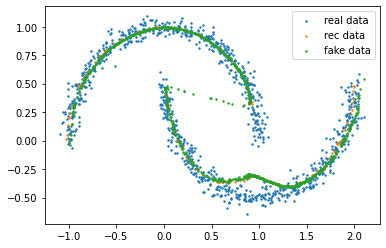

step 9000: KL: 5.250e+02, rec: 1.887e+03


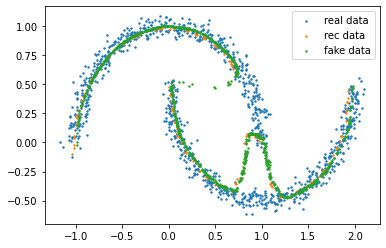

step 10000: KL: 5.114e+02, rec: 1.788e+03


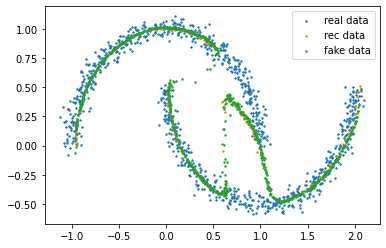

step 11000: KL: 5.372e+02, rec: 1.841e+03


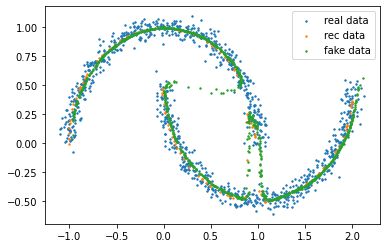

step 12000: KL: 5.366e+02, rec: 1.745e+03


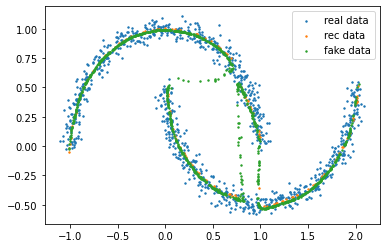

step 13000: KL: 5.425e+02, rec: 1.783e+03


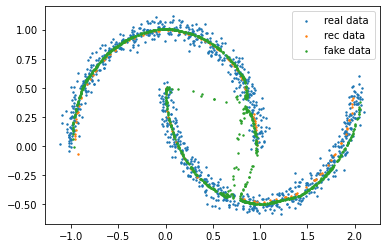

step 14000: KL: 5.504e+02, rec: 1.772e+03


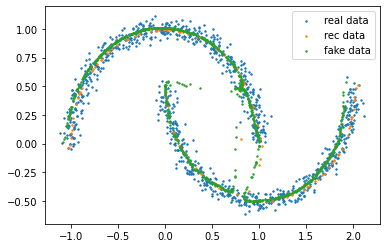

step 15000: KL: 5.454e+02, rec: 1.765e+03


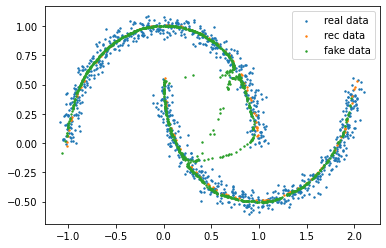

step 16000: KL: 5.517e+02, rec: 1.659e+03


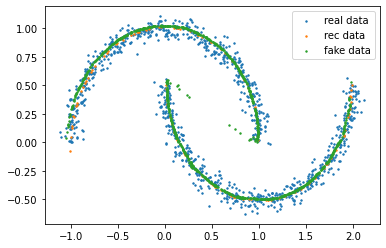

step 17000: KL: 5.358e+02, rec: 1.910e+03


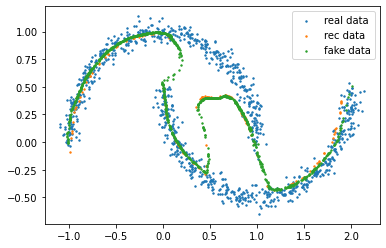

step 18000: KL: 5.391e+02, rec: 1.809e+03


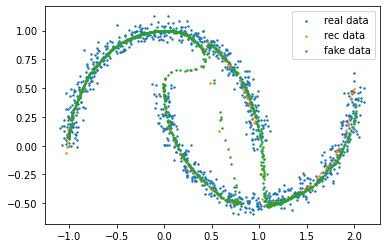

step 19000: KL: 5.567e+02, rec: 1.705e+03


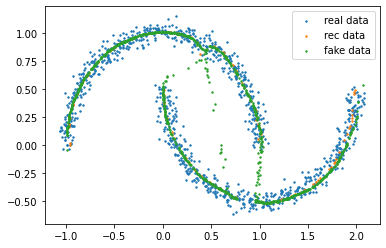

step 20000: KL: 5.395e+02, rec: 1.853e+03


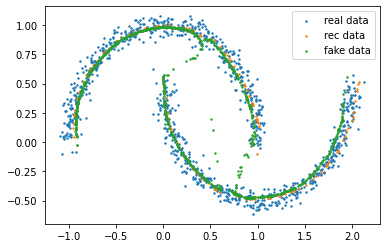

In [30]:
# Total number of training iterations for the VAE
N_ITER = 20001
# Batch size to use
BATCHLEN = 128

encoder = Encoder()
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))

# --- Instance modified decoder --- #
decoder = Decoder()

optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()
    
    x = generate_batch(BATCHLEN)
    
    enc_mu, enc_logvar = encoder(x)
    #
    # COMPUTE THE KL PART OF THE LOSS HERE
    #
    loss_kl = 0.5 * torch.sum( torch.exp(enc_logvar) + enc_mu.pow(2) - 1 - enc_logvar)
    #
    # SAMPLE z FROM q(z|x) HERE
    #
    enc_sig = torch.exp(0.5*enc_logvar)
    z = enc_mu + enc_sig * torch.randn((BATCHLEN,LATENT_N))
    
    dec_mu, dec_logvar = decoder(z)
    #
    # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
    #
    loss_rec = 0.5 * torch.sum(dec_logvar + (x - dec_mu).pow(2) * torch.exp(-dec_logvar) + LATENT_N * np.log(2 * np.pi))

    (0.25*loss_kl + loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if i%1000 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        # plot the result
        real_batch = generate_batch(1024)
        rec_batch = torch.normal(dec_mu, 1e-4).detach()
        fake_batch = decoder.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

> **Observation:** <br> 
* We first notice that we obtain better results with the modified architecture. 
* Moreover, in this case of too low variance, the fake data and the reconstructed data are very close to the two-moon distribution. We also observe that the fake data follows almost perfectly the reconstructed data. 
* Another point to mention is that the learning is not stable. At some stages, the fake data diverges from the two-moon distribution which means that it is too sensitive to the changes of the reconstructed data in the case of too small variance. 
* That said, in this case, the fake data may overfit the reconstructed data and fail to generalize to the training data.

**Q13: How do the power of encoder and decoder affect the overall training of the VAE?**

> The VAE is trained in two steps, the first is the encoder training and the second is the decoder training. 
> <br><br>
> - On one hand, the encoder can significantly influence the overall learning of the VAE. It determines the ability of the VAE to embed data in an alternative latent space. Since the encoder encodes data in a low-dimensional space, the compact representation of the training data affects the overall VAE model. Thus, the more accurate the latent space created, the fewer errors are obtained during data reconstruction. <br>
When we chose a low power of the encoder (low number of layers (3)), the performance of the model is low which means that the encoding of the input data is poor. From $6$ layers, we can see that the encoder is able to generalize well and capture both classes of the two moons data.
> <br><br>
> - On the other hand, the decoder determines the ability of the VAE to reconstruct the data. The effect of the decoder is less than that of the encoder. Since providing a better representation of the latent space can help the decoder better reconstruct input data. The only point on which the decoder can play the role is to affect the reconstruction of new images from the embeddings created by the encoder. We can also notice the same results as before, for low power of the decoder, the reconstructed data do not fit the two moons. For higher values, the reconstruction results match better the real data.

### Normalizing flows

Another approach to generative modelling is given by Normalizing flows. The idea is to learn a mapping $f$ from the data distribution $p_D$ (defined over a space $\mathcal{X}$) to a known distribution (typically, a normal distribution) from which we know how to sample. Two key points are to be noted:
1. The mapping needs to be bijective (i.e., the network needs to be invertible).
2. The exact likelihood of a data point should be easily computable.

To tackle point 2, let us introduce some notations.
Let us denote by $p_\mathcal{N} = \mathcal{N}(0,1)$ the normal distribution from which we sample $z$. We obtain points $x$ by computing $x = f^{-1}(z)$, and we hope that the distribution of points obtained this way will match more or less the dataset distribution $p_D$ of real examples.
We denote by $p_G$ this obtained distribution, that is, the image of $p_\mathcal{N}$ through $f^{-1}$: $p_G$ is a probability distribution defined on $\mathcal{X}$, and our goal will be to optimize the mapping $f$ so that $p_G$ is close to $p_D$. If you are not familiar with images of distributions, the definition is here: https://en.wikipedia.org/wiki/Pushforward_measure ; it can be defined as the measure that satisfies this change of variables: $\int_{z\sim p_\mathcal{N}} g(f^{-1}(z)) dz = \int_{x\sim p_{G}} g(x) dx$ for all functions $g$. Another notation for this is $\int_{z} g(f^{-1}(z)) \;dp_\mathcal{N}(z) = \int_{x} g(x) \;dp_{G}(x)$. 
We will build on the following identity:
$$
\log(p_X(x))=\log(p_Z(z))+\log \det J_f
$$
where $J_f = \frac{df(x)}{dx}$ is the Jacobian matrix of the function $f$.

**Q14: Justify the above equality**

> We have, 
$$
\begin{array}{ll}
\int_{z} g(f^{-1}(z)) \;dp_Z(z)  & = \int_{x} g(x) \;dp_X(x)  = \int_{x} g(x) \;p_X(x)  dx \\
\int_{z} g(f^{-1}(z)) \;dp_Z(z) & = \int_{f(X)} g(f^{-1}(z)) \;dp_Z(f(x))  \\
\end{array}
$$ <br>
> Or, 
$$
\begin{array}{ll}
\int_{\Phi (U)} f(x,y) ~ dx~ dy  & =\int_{U}f(\Phi(u,v)\left|\det J_{\Phi }(u,v)\right|  du~dv \\
\end{array}
$$ <br>
> Thus, 
$$
\begin{array}{ll}
\int_{f(X)} g(f^{-1}(z)) \;dp_Z(f(x)) & = \int_x g(f^{-1}(f(x))) ~~ |\det{J_f}| ~~p_Z(f(x))~dx \\
& =  \int_x g(x)~ ~|\det{J_f}|~ ~p_Z(f(x))~ dx \\
& = \int_{x,z=f(x)} g(x) ~~|\det{J_f}|~~ p_Z(z)~ dx \\
\end{array}
$$ <br>
> We found, 
$$
\begin{array}{ll}
\int_{x} g(x)~ |\det{J_f}| ~p_Z(z) ~dx &  = \int_{x} g(x) \;p_X(x)  dx \\\\
 p_X(x)  = |\det{J_f}|~ p_Z(z) \\
\end{array}
$$ <br>
> Conclusion, 
$$
\boxed{\log(p_X(x))=\log(p_Z(z))+\log \det J_f}
$$

Let us consider, as an optimization criterion, the Kullback-Leibler divergence $KL(p_D||p_G)$.

**Q15: Express this loss as a (very simple) function of the quantity above.**

> We have, 
$$\begin{array}{ll}
KL(p_D||p_G) & = \mathbb{E}_{p_D}\left(\log(p_D) - \log(p_G) \right) \\
& = \mathbb{E}_{p_D}\left(\log(p_D)  \right)  - \mathbb{E}_{p_D}\left(\log(p_G) \right)
\end{array} $$
<br> 
> $P_G \sim P_X(x) $ and the left term does not depend on $P_G$. Thus, <br><br>
$$\begin{array}{ll}
Loss & = - \mathbb{E}_{p_D}\left(\log(P_X(x)) \right) \\
& = - \mathbb{E}_{p_D} \left( \log(p_Z(z))+\log \det J_f  \right) 
\end{array}$$

A challenging task is then to find a network, such that f is:
* invertible
* $\det J_f$ is tractable
* $f$ is general enough

A common architecture is the so called real-valued non-volume preserving (real-NVP), which is made of coupling layers.

The idea of coupling layers is to cut the input $x$ in two (let say keeping only the $d < D$ first dimensions on one hand and the $D-d$ other dimensions on the other hand, with $D$ the dimension of the input space $\mathcal{X}$). This gives inputs $x_{1:d}$ and $x_{d+1:D}$. Then the forward pass is defined as:
* $y_{1:d}=x_{1:d}$
* $y_{d+1:D}=x_{d+1:D}\odot \exp(s(x_{1:d})) + t(x_{1:d})$

where $s,t:\mathbb{R}^d\to\mathbb{R}^{D-d}$ and $\odot$ is the coefficient-wise multiplication of two vectors of the same size.

Those equations can be resumed in the following diagram:
![real NVP diagram](realNVPforward.png)

**Q16: Show that the defined mapping is indeed invertible**

> To show that the defined mapping is invertible, it is sufficient to write :
<br>
* $x_{1:d}$ in function of only $y_{1:d}$ and $y_{d+1:D}$
* $x_{d+1:D}$ in function of only $y_{1:d}$ and $y_{d+1:D}$
>
> For the first, we already have :
* $y_{1:d} = x_{1:d} \implies x_{1:d} = y_{1:d}  $
>
>For the second, 
* $y_{d+1:D} = x_{d+1:D} \odot exp(s(x_{1 :d})) + t(x_{1 :d})$
<br> $\Longleftrightarrow$ <br>
$x_{d+1:D} \odot exp(s(x_{1 :d})) = y_{d+1:D} - t(x_{1 :d})$
<br> $\Longleftrightarrow$ <br>
$x_{d+1:D} \odot \underbrace{exp(s(x_{1 :d}))  \odot exp(-s(x_{1 :d}))}_{=1}  = (y_{d+1:D} - t(x_{1 :d}))  \odot exp(-s(x_{1 :d}))$
<br> $\Longleftrightarrow$ <br>
$x_{d+1:D}  = (y_{d+1:D} - t(x_{1 :d}))  \odot exp(-s(x_{1 :d}))$
>
>Thus, we obtain :
$$\boxed{
x_{1:d} = y_{1:d}  \\
x_{d+1:D} = (y_{d+1:D} - t(y_{1 :d})) \odot exp(-s(y_{1 :d}))
}$$ <br>
Therefore, the defined mapping is indeed invertible.


**Q17: Show that the determinant of the Jacobian of such a mapping is $\exp(\sum_j s(x_{1:d})_j)$**

> The jacobian of the mapping $f$ is given by : $J_f = \frac{\partial f(x)}{ \partial x} = \frac{\partial y}{\partial x} = 
\begin{pmatrix}
 \frac{\partial y_{1:d}} {\partial x_{1:d}}  &  \frac{\partial y_{1:d}}{\partial x_{d+1:D}}  \\
\frac{\partial y_{d+1:D}}{\partial x_{1:d}}  &  \frac{\partial y_{d+1:D}}{\partial x_{d+1:D}}  
\end{pmatrix}
$
<br>
* $\frac{\partial y_{1:d}} {\partial x_{1:d}}  = ~? ~~~~~~\frac{\partial y_{1:d}}{\partial x_{d+1:D}} = ~? $ <br><br>
$y_{1:d} = x_{1:d}  \implies \forall i \in [1,..,d], y_i = x_i \implies \forall i,j \in [1,..,d], \frac{\partial y_i }{\partial x_j} = \delta_{i,j} =\left\{
    \begin{array}{ll}
        1 & \mbox{if} ~i=j \\
        0 & \mbox{otherwise.}
    \end{array}
\right.$ <br> <br>
$\implies \left\{
    \begin{array}{l}
        \frac{\partial y_{1:d}}{\partial x_{1:d}} = \mathbf{1}_d \\
        \frac{\partial y_{1:d}}{\partial x_{d+1:D}} = \mathbf{0}_d
    \end{array}
\right.$
<br><br>
* $\frac{\partial y_{d+1:D}}{\partial x_{d+1:D}}  = ~?$ 
<br><br>
$y_{d+1:D}=x_{d+1:D}\odot \exp(s(x_{1:d})) + t(x_{1:d}) \implies \frac{\partial y_{d+1:D}}{x_{d+1:D}} = Diag \left(exp(s(x_{1:d}))\right)$
>
> <br> Therefore, $~~~~~J_f = 
\begin{pmatrix}
 \frac{\partial y_{1:d}} {\partial x_{1:d}}  &  \frac{\partial y_{1:d}}{\partial x_{d+1:D}}  \\
\frac{\partial y_{d+1:D}}{\partial x_{1:d}}  &  \frac{\partial y_{d+1:D}}{\partial x_{d+1:D}}  
\end{pmatrix}
=
\begin{pmatrix}
 \mathbf{1_d} & \mathbf{0_d} \\
(\star)  & Diag \left(exp(s(x_{1:d}))\right)
\end{pmatrix}
$
<br><br>Thus, $~~~~|J_f| = |\mathbf{1_d}| \times |exp(s(x_{1:d}))| = 1 \times \prod_j exp(s(x_{1:d})_j) = exp(\sum_j s(x_{1:d})_j) $
>
><br><br>
> Hence, the determinant of the jacobian of such a mapping is equal to $\boxed{exp(\sum_j s(x_{1:d})_j) }$.

**Q18: Fill the Coupling layer structure below by defining suitable functions sfun and tfun (using a final tanh in sfun is highly recommended) and the inverse pass**

In [31]:
import torch
from torch import nn
from torch.nn import functional as F


class CouplingLayer(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask):
        super().__init__()
        ### define here variables to use in f and s ###
        self.s = nn.Sequential(nn.Linear(input_size,hidden_size),
                              nn.ReLU(inplace = True),
                              nn.Linear(hidden_size,hidden_size),
                              nn.ReLU(inplace = True), 
                              nn.Linear(hidden_size,output_size),
                              nn.Tanh()
                              )
        
        self.t = nn.Sequential(nn.Linear(input_size,hidden_size),
                              nn.ReLU(inplace = True),
                              nn.Linear(hidden_size,hidden_size),
                              nn.ReLU(inplace = True), 
                              nn.Linear(hidden_size,output_size),
                              )
        ###
        self.mask = mask #we use the mask variable to make the cut in input

    def sfun(self, x_m):
        x_m = self.s(x_m)
        return x_m
        
    def tfun(self, x_m):
        x_m = self.t(x_m)
        return x_m
        
    def forward(self, x):
        x_m = x * self.mask
        s_out = self.sfun(x_m) # multiplicative block
        t_out = self.tfun(x_m) # additive block
        y = x_m + (1-self.mask)*(x*torch.exp(s_out)+t_out)
        log_det_jacobian = s_out.sum(dim=1)  # CRITICAL
        return y, log_det_jacobian

    def inverse(self, y):
        y_m = y * self.mask
        y = torch.exp(-self.sfun(y_m)) * ((1 - self.mask) * y - self.tfun(y_m)) + y_m
        return y

In [32]:
class RealNVP(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask, n_layers=6):
        super().__init__()
        assert n_layers >= 2, "num of coupling layers should be greater or equal to 2"

        self.modules = []
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        for _ in range(n_layers-2):
            mask = 1 - mask
            self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, 1 - mask))
        self.module_list = nn.ModuleList(self.modules)

    def forward(self, x):
        ldj_sum = 0  # sum of log determinant of jacobian
        for module in self.module_list:
            x, ldj = module(x)
            ldj_sum += ldj
        return x, ldj_sum

    def inverse(self, z):
        for module in reversed(self.module_list):
            z = module.inverse(z)
        return z

In [33]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch


def train(epoch, model, optimizer, prior_z, train_loader, log_interval=50):
    model.train()
    train_loss = 0
    for batch_idx, x_inputs in enumerate(train_loader):
        optimizer.zero_grad()
        z_outputs, log_det_j_sum = model.forward(x_inputs)  # train with the forward
        loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean()  # CRITICAL
        loss.backward()
        cur_loss = loss.item()
        train_loss += cur_loss
        optimizer.step()
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(x_inputs), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), cur_loss / len(x_inputs)))

    average_train_loss = train_loss / len(train_loader.dataset)
    print(f"====> Epoch: {epoch} Average train loss: {average_train_loss:.4f}")


def test(epoch, model, prior_z, test_loader):
    model.eval()
    test_loss = 0
    x_all = np.array([[]]).reshape(0, 2)
    z_all = np.array([[]]).reshape(0, 2)
    with torch.no_grad():
        for batch_idx, x_inputs in enumerate(test_loader):
            z_outputs, log_det_j_sum = model.forward(x_inputs)
            cur_loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean().item()
            test_loss += cur_loss
            x_all = np.concatenate((x_all, x_inputs.numpy()))
            z_all = np.concatenate((z_all, z_outputs.numpy()))

        subfig_plot(1, x_all, -2, 3, -1, 1.5, "Input: x ~ p(x)", "b")
        subfig_plot(2, z_all, -3, 3, -3, 3, "Output: z = f(x)", "b")

        test_loss /= len(test_loader.dataset)
        print(f"====> Test loss: {test_loss:.4f}")


def sample(epoch, model, prior_z, save_plt_interval=5):
    model.eval()
    with torch.no_grad():
        z_inputs = prior_z.sample((1000,))
        x_outputs = model.inverse(z_inputs)  # generation with the inverse
        z_inputs = z_inputs.numpy()
        x_outputs = x_outputs.numpy()

        subfig_plot(3, z_inputs, -3, 3, -3, 3, "Input: z ~ p(z)", "r")
        subfig_plot(4, x_outputs, -2, 3, -1, 1.5, "Output: x = g(z) (g: inverse of f)", "r")

        if epoch % save_plt_interval == 0:
            if not os.path.exists("results"):
                os.makedirs("results")
            plt.savefig("results/"+"result_"+str(epoch)+".png")


def subfig_plot(location, data, x_start, x_end, y_start, y_end, title, color):
    if location == 1:
        plt.clf()
    plt.subplot(2, 2, location)
    plt.scatter(data[:, 0], data[:, 1], c=color, s=1)
    plt.xlim(x_start, x_end)
    plt.ylim(y_start, y_end)
    plt.title(title)
    plt.pause(1e-2)

In [34]:
# globals
BATCH_SIZE = 128
LOG_INTERVAL = 50
N_EPOCHS = 10
INPUT_SIZE = 2
OUTPUT_SIZE = 2
HIDDEN_SIZE = 256
SAVE_PLT_INTERVAL = 5
N_COUPLING_LAYERS = 8

In [35]:
# data loading
train_data = datasets.make_moons(n_samples=50000, noise=.05)[0].astype(np.float32)
test_data = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loader_kwargs = {"num_workers": 1, "pin_memory": True} if device == "cuda" else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)

In [17]:
from torch import distributions # optim, 
# model construction
mask = torch.from_numpy(np.array([0, 1]).astype(np.float32))
model = RealNVP(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_SIZE, mask, N_COUPLING_LAYERS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
prior_z = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

Train Epoch: 1 [0/50000 (0%)]	Loss: -0.059682
Train Epoch: 1 [6400/50000 (13%)]	Loss: -0.059951
Train Epoch: 1 [12800/50000 (26%)]	Loss: -0.059840
Train Epoch: 1 [19200/50000 (38%)]	Loss: -0.060673
Train Epoch: 1 [25600/50000 (51%)]	Loss: -0.060155
Train Epoch: 1 [32000/50000 (64%)]	Loss: -0.059725
Train Epoch: 1 [38400/50000 (77%)]	Loss: -0.059125
Train Epoch: 1 [44800/50000 (90%)]	Loss: -0.058746
====> Epoch: 1 Average train loss: -0.0597


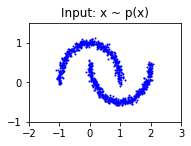

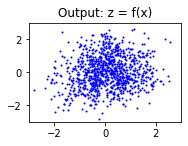

====> Test loss: -0.0608


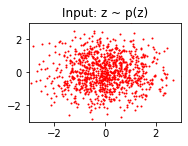

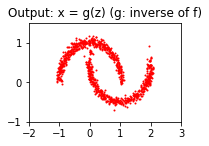

Train Epoch: 2 [0/50000 (0%)]	Loss: -0.059078
Train Epoch: 2 [6400/50000 (13%)]	Loss: -0.060458
Train Epoch: 2 [12800/50000 (26%)]	Loss: -0.060008
Train Epoch: 2 [19200/50000 (38%)]	Loss: -0.060117
Train Epoch: 2 [25600/50000 (51%)]	Loss: -0.059840
Train Epoch: 2 [32000/50000 (64%)]	Loss: -0.059413
Train Epoch: 2 [38400/50000 (77%)]	Loss: -0.060151
Train Epoch: 2 [44800/50000 (90%)]	Loss: -0.059145
====> Epoch: 2 Average train loss: -0.0597


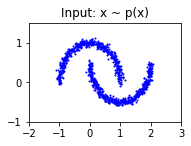

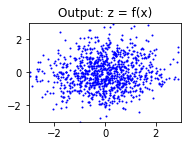

====> Test loss: -0.0610


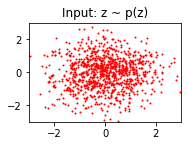

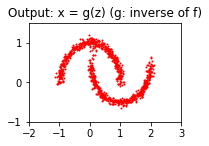

Train Epoch: 3 [0/50000 (0%)]	Loss: -0.060507
Train Epoch: 3 [6400/50000 (13%)]	Loss: -0.060324
Train Epoch: 3 [12800/50000 (26%)]	Loss: -0.058785
Train Epoch: 3 [19200/50000 (38%)]	Loss: -0.058961
Train Epoch: 3 [25600/50000 (51%)]	Loss: -0.060533
Train Epoch: 3 [32000/50000 (64%)]	Loss: -0.059960
Train Epoch: 3 [38400/50000 (77%)]	Loss: -0.059464
Train Epoch: 3 [44800/50000 (90%)]	Loss: -0.059550
====> Epoch: 3 Average train loss: -0.0597


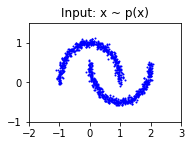

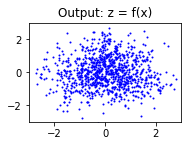

====> Test loss: -0.0610


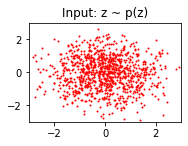

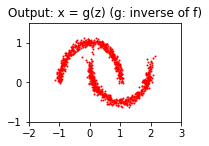

Train Epoch: 4 [0/50000 (0%)]	Loss: -0.059375
Train Epoch: 4 [6400/50000 (13%)]	Loss: -0.060431
Train Epoch: 4 [12800/50000 (26%)]	Loss: -0.059187
Train Epoch: 4 [19200/50000 (38%)]	Loss: -0.059650
Train Epoch: 4 [25600/50000 (51%)]	Loss: -0.059274
Train Epoch: 4 [32000/50000 (64%)]	Loss: -0.059862
Train Epoch: 4 [38400/50000 (77%)]	Loss: -0.058742
Train Epoch: 4 [44800/50000 (90%)]	Loss: -0.059648
====> Epoch: 4 Average train loss: -0.0597


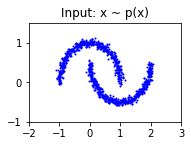

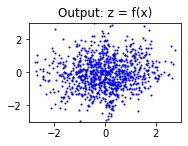

====> Test loss: -0.0609


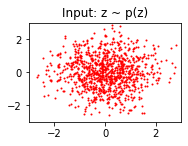

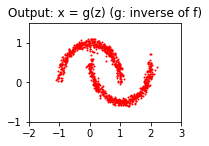

Train Epoch: 5 [0/50000 (0%)]	Loss: -0.059483
Train Epoch: 5 [6400/50000 (13%)]	Loss: -0.059037
Train Epoch: 5 [12800/50000 (26%)]	Loss: -0.059439
Train Epoch: 5 [19200/50000 (38%)]	Loss: -0.059734
Train Epoch: 5 [25600/50000 (51%)]	Loss: -0.060247
Train Epoch: 5 [32000/50000 (64%)]	Loss: -0.059507
Train Epoch: 5 [38400/50000 (77%)]	Loss: -0.059520
Train Epoch: 5 [44800/50000 (90%)]	Loss: -0.059456
====> Epoch: 5 Average train loss: -0.0597


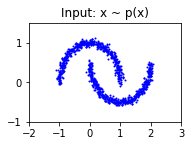

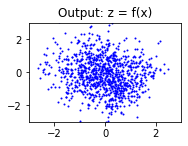

====> Test loss: -0.0608


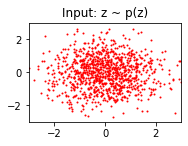

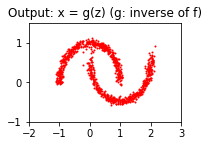

Train Epoch: 6 [0/50000 (0%)]	Loss: -0.060599
Train Epoch: 6 [6400/50000 (13%)]	Loss: -0.058708
Train Epoch: 6 [12800/50000 (26%)]	Loss: -0.059894
Train Epoch: 6 [19200/50000 (38%)]	Loss: -0.058794
Train Epoch: 6 [25600/50000 (51%)]	Loss: -0.059738
Train Epoch: 6 [32000/50000 (64%)]	Loss: -0.060070
Train Epoch: 6 [38400/50000 (77%)]	Loss: -0.059623
Train Epoch: 6 [44800/50000 (90%)]	Loss: -0.059262
====> Epoch: 6 Average train loss: -0.0597


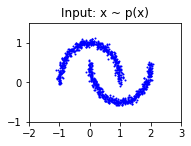

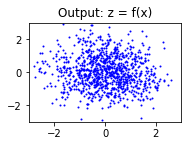

====> Test loss: -0.0611


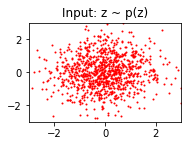

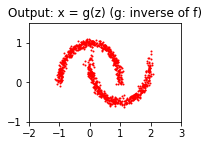

Train Epoch: 7 [0/50000 (0%)]	Loss: -0.060127
Train Epoch: 7 [6400/50000 (13%)]	Loss: -0.059184
Train Epoch: 7 [12800/50000 (26%)]	Loss: -0.059612
Train Epoch: 7 [19200/50000 (38%)]	Loss: -0.060206
Train Epoch: 7 [25600/50000 (51%)]	Loss: -0.059861
Train Epoch: 7 [32000/50000 (64%)]	Loss: -0.060574
Train Epoch: 7 [38400/50000 (77%)]	Loss: -0.060383
Train Epoch: 7 [44800/50000 (90%)]	Loss: -0.059734
====> Epoch: 7 Average train loss: -0.0598


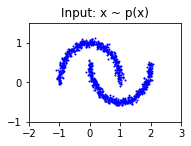

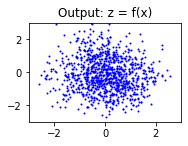

====> Test loss: -0.0610


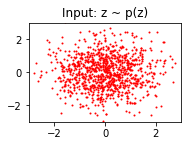

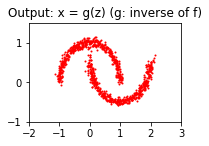

Train Epoch: 8 [0/50000 (0%)]	Loss: -0.060325
Train Epoch: 8 [6400/50000 (13%)]	Loss: -0.060119
Train Epoch: 8 [12800/50000 (26%)]	Loss: -0.059937
Train Epoch: 8 [19200/50000 (38%)]	Loss: -0.058938
Train Epoch: 8 [25600/50000 (51%)]	Loss: -0.059281
Train Epoch: 8 [32000/50000 (64%)]	Loss: -0.059350
Train Epoch: 8 [38400/50000 (77%)]	Loss: -0.059560
Train Epoch: 8 [44800/50000 (90%)]	Loss: -0.060128
====> Epoch: 8 Average train loss: -0.0598


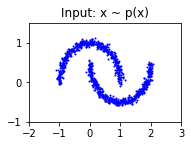

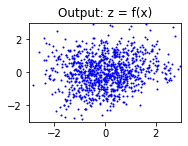

====> Test loss: -0.0609


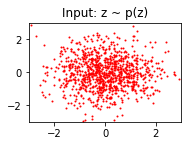

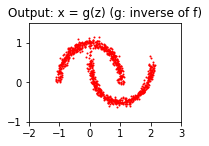

Train Epoch: 9 [0/50000 (0%)]	Loss: -0.059689
Train Epoch: 9 [6400/50000 (13%)]	Loss: -0.059064
Train Epoch: 9 [12800/50000 (26%)]	Loss: -0.059839
Train Epoch: 9 [19200/50000 (38%)]	Loss: -0.059992
Train Epoch: 9 [25600/50000 (51%)]	Loss: -0.060005
Train Epoch: 9 [32000/50000 (64%)]	Loss: -0.059273
Train Epoch: 9 [38400/50000 (77%)]	Loss: -0.059385
Train Epoch: 9 [44800/50000 (90%)]	Loss: -0.059334
====> Epoch: 9 Average train loss: -0.0598


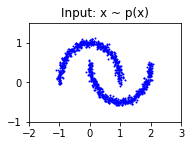

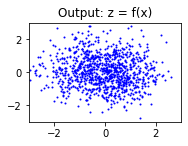

====> Test loss: -0.0611


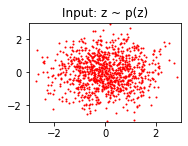

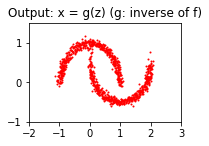

Train Epoch: 10 [0/50000 (0%)]	Loss: -0.059974
Train Epoch: 10 [6400/50000 (13%)]	Loss: -0.060350
Train Epoch: 10 [12800/50000 (26%)]	Loss: -0.058813
Train Epoch: 10 [19200/50000 (38%)]	Loss: -0.060939
Train Epoch: 10 [25600/50000 (51%)]	Loss: -0.058835
Train Epoch: 10 [32000/50000 (64%)]	Loss: -0.059693
Train Epoch: 10 [38400/50000 (77%)]	Loss: -0.059995
Train Epoch: 10 [44800/50000 (90%)]	Loss: -0.060254
====> Epoch: 10 Average train loss: -0.0598


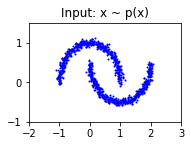

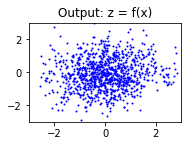

====> Test loss: -0.0610


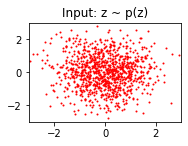

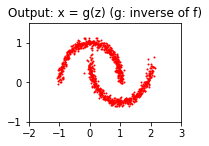

'164.79s'

<Figure size 432x288 with 0 Axes>

In [36]:
from timeit import default_timer as timer
# run
start = timer()
for epoch in range(1, N_EPOCHS + 1):
    train(epoch, model, optimizer, prior_z, train_loader)
    test(epoch, model, prior_z, test_loader)
    sample(epoch, model, prior_z)
f"{timer() - start:.02f}s"

**Q19: Explain why Normalizing flows do not fit well when there are many clusters in data**

> By exploring the objective function to be optimized, we can clearly see that it involves the determinant of the Jacobian. Thus, if we have many clusters in the data, the learned mapping function between the distribution of the data and the normal distribution will tend to bring the points that belong to the same clusters closer together and move the points that do not belong to the same clusters further away. This can lead to vanishing or exploding gradients since the computation of the determinant of the Jacobian is critical and can easily diverge.

**Q20: As a conclusion, how would you compare the advantages and shortcomings of GANs, VAEs and Normalizing flows?**

> - The first advantage that we can think of is concerning the optimization problem. Actually, we can acquire an accurate estimate of the likelihood of samples with Normalizing flows models. However, VAEs optimize a lower bound on the likelihood, and GANs minimize the difference between the input and the noise distributions. Added to that, for the Normalizing flows, there is no noise in the outputs, so that as explored in Q18, we have great local variance models. However, as we explained in Q19, computing the determinant of the Jacobian can be tricky, especially in the presence of multiple clusters, so we could easily diverge. Also, the expressive power of the coupling layers have to be very good in order to model correclty complex data distribution (the use of deep neural networks).
<br><br>
> - GAN is designed specifically for generative problems. Although GANs are less expressive, their goal of approximating data distributions with modified noise distributions can provide the sharpest results, especially visually. The duality between the generator and disciminator always gives the best result. However, training GANs is always the most difficult and can result in collapsing models, which can be avoided by various versions of GANs (such as Wasserstein GAN).
<br><br>
> - VAEs are the most expressive of all the models, as they provide interpretive space by learning smooth latent state representations of the input data. However, due to the added noise and imperfect reconstruction, the generated samples are much blurrier than those from GANs.

